In [1]:
import os, sys
from glob import glob
from os import listdir
from os.path import isfile, join
from scipy import io
from scipy import stats 
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from collections import OrderedDict 

from utils import word2sense, regression, image_to_tensor, Subject

from feature_extractors import AlexNetFC6, AlexNetConv5
import torch

In [3]:
fmri_path = "predicted_LOC_conv5"
p = os.path.join(os.getcwd(), fmri_path) 
conditions = sorted(listdir(p))
condition_voxels = {}
for condition in conditions:
    file_name = listdir((os.path.join(p, condition)))[0]
    file_path = os.path.join(p, condition, file_name)
    condition_voxels[condition] = np.load(file_path)

pred_voxels = np.stack([condition_voxel for condition, condition_voxel in OrderedDict(condition_voxels).items()])
#print(np.shape(pred_voxels)) # should be 1470, 200
_, embeddings = word2sense("ThingsWrd2Sns.txt")


# Option 1B: Object2vec fMRI
o2v = False
if o2v == True:
    roi = 'LOC'
    roistack = io.loadmat('data/fmri/subj{:03}'.format(1) +
                                        '/roistack.mat')['roistack']

    roi_names_o2v = [d[0] for d in roistack['rois'][0, 0][:, 0]]
    conditions_o2v = [d[0] for d in roistack['conds'][0, 0][:, 0]]
    roi_indices = roistack['indices'][0, 0][0]
    roi_masks = {roi: roi_indices == (i + 1) for i, roi in enumerate(roi_names_o2v)}
    voxels = roistack['betas'][0, 0]
    object2vec_voxels = {cond: np.concatenate([voxels[i][roi_masks[roi]]])
                             for i, cond in enumerate(conditions_o2v)}
    object2vec_voxels = np.stack([object2vec_voxels[c] for c in object2vec_voxels])

In [7]:
kf9 = KFold(n_splits = 9)
l2 = 0.0
randomvector = True
mean_r_set = np.empty((1, 2250))

for pc in range(5, 20, 1):
    rs = []
    mean_r = {}
    pca = PCA(n_components=pc)
    for train_index, test_index in tqdm(kf9.split(pred_voxels),total=kf9.n_splits):
        train_voxels = pred_voxels[train_index,]
        test_voxels =  pred_voxels[test_index,]
        if pc != 0:
            if o2v == True: # Option 1B
                pca.fit(object2vec_voxels)
            else: # Option 1A
                pca.fit(train_voxels)
            #train_voxels_reduced = pca.transform(train_voxels)
            #train_voxels_invert = pca.inverse_transform(train_voxels_reduced)       
            train_voxels = pca.transform(train_voxels)
            test_voxels = pca.transform(test_voxels)
        #print(np.shape([embedding for i, embedding in enumerate(embeddings.values()) if i in train_index]))
        train_embeddings = np.stack([embedding for i, embedding in enumerate(embeddings.values()) if i in train_index])
        test_embeddings = np.stack([embedding for i, embedding in enumerate(embeddings.values()) if i in test_index])
        _, r = regression(train_voxels, train_embeddings, test_voxels, test_embeddings, l2=l2)
        rs.append(r)
    rs = np.array(rs)
    print(rs.shape)
    mean_r = np.nanmean(rs, axis=0)
    print(mean_r)
    mean_r_set = np.append(mean_r_set, [mean_r], axis=0)
    #Saved information
    #np.save( ROI + "_" + layer, mean_r)

  0%|          | 0/9 [00:00<?, ?it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:02,  2.84it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:02,  3.07it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.25it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.34it/s]/home/chan21/projects/seman

(9, 2250)
[ 0.18047544  0.10129688  0.02607023 ...  0.05859149 -0.00815294
  0.0774843 ]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.54it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.56it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.58it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.63it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.17700849 0.09826192 0.02118509 ... 0.05494668 0.00365711 0.04970306]


 11%|█         | 1/9 [00:00<00:02,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:02,  3.45it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.56it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.62it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.68it/s]/home/chan21/projec

(9, 2250)
[0.19860183 0.09718497 0.01652542 ... 0.06321236 0.01503768 0.0627765 ]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.80it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.79it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.80it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.80it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19768863 0.09382635 0.02353714 ... 0.05370744 0.01455012 0.06618275]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.82it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.82it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.81it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.81it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19358641 0.09578893 0.02038461 ... 0.06156943 0.02089021 0.05410271]


 11%|█         | 1/9 [00:00<00:02,  3.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.72it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.70it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.72it/s]/home/chan21/projec

(9, 2250)
[0.1945569  0.12092801 0.0128311  ... 0.05358284 0.02171734 0.05076263]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.55it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.62it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.62it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.63it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19548981 0.1262115  0.0112326  ... 0.05161051 0.06842355 0.05085495]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.73it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.74it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.66it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19106207 0.12061516 0.04575624 ... 0.04751036 0.0663939  0.04997015]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.76it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19013996 0.12273227 0.04083769 ... 0.05082401 0.06847975 0.04949847]


 11%|█         | 1/9 [00:00<00:02,  3.79it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.80it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.79it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.78it/s]/home/chan21/projec

(9, 2250)
[0.18900103 0.12293593 0.03880585 ... 0.05103475 0.06607667 0.04712627]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.18830712 0.10762295 0.03186545 ... 0.0484977  0.06478127 0.05910313]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.79it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.18644692 0.10682209 0.02195231 ... 0.05236543 0.0693438  0.07481731]


 11%|█         | 1/9 [00:00<00:02,  3.80it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.76it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.74it/s]/home/chan21/projec

(9, 2250)
[0.18829429 0.1017321  0.01783591 ... 0.04670769 0.07551858 0.08054342]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.36it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.23it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.16it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19126678 0.10564551 0.05646625 ... 0.12816999 0.0744192  0.08097458]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:00<00:01,  3.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:00<00:01,  3.79it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:01<00:01,  3.79it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 56%|█████▌    | 5/9 [00:01<00:01,  3.76it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
[0.19173186 0.1056604  0.05525321 ... 0.1274701  0.08182545 0.086035  ]



<ipython-input-7-da9c5aeaa545>:29: RuntimeWarning: Mean of empty slice
  mean_r = np.nanmean(rs, axis=0)


In [ ]:
feat_extractor = AlexNetConv5()
predictions = {}
stimuli_folder_path = os.path.join(os.getcwd(), 'images/')
for c in tqdm(conditions):
    stimuli_path = [os.path.join(stimuli_folder_path, c, s) for s in listdir(os.path.join(stimuli_folder_path, c))]
    for s in stimuli_path:
        if ".DS_Store" in s:
            stimuli_path.remove(s)
    print(stimuli_path)
    stimuli = [image_to_tensor(s, resolution=256) for s in stimuli_path]
    stimuli = torch.stack(stimuli)
    with torch.no_grad():
        preds = feat_extractor(stimuli).mean(dim=0).cpu().numpy() 
    predictions[c] = preds

torch.save(predictions, os.path.join('features_conv5' + '.pth'))

In [5]:
# Load presaved features
predictions = torch.load(os.path.join('features_conv5' + '.pth'))

In [8]:
print(len(predictions))
pred_features = np.stack([condition_feature for condition, condition_feature in OrderedDict(predictions).items()])
print(pred_features.shape)


l2 = 0.0
randomvector = False
mean_r_feature_set = np.empty((1, 2250))

for pc in range(5, 20, 1):
    rs = []
    mean_r_feature = {}
    pca = PCA(n_components=pc)

    for train_index, test_index in tqdm(kf9.split(pred_features),total=kf9.n_splits):
        train_features = pred_features[train_index,]
        test_features =  pred_features[test_index,] 
        if pc != 0:
            pca.fit(train_features)
            #train_voxels_reduced = pca.transform(train_voxels)
            #train_voxels_invert = pca.inverse_transform(train_voxels_reduced)       
            train_features = pca.transform(train_features)
            test_features = pca.transform(test_features)
        #print(np.shape([embedding for i, embedding in enumerate(embeddings.values()) if i in train_index]))
        train_embeddings = np.stack([embedding for i, embedding in enumerate(embeddings.values()) if i in train_index])
        test_embeddings = np.stack([embedding for i, embedding in enumerate(embeddings.values()) if i in test_index])

            #train_embeddings = np.random.rand(train_embeddings.shape[0], train_embeddings.shape[1])
        #print(np.shape(train_voxels), np.shape(test_voxels), np.shape(train_embeddings), np.shape(test_embeddings))
        _, r = regression(train_features, train_embeddings, test_features, test_embeddings, l2=l2)
        rs.append(r)
    rs = np.array(rs)
    print(rs.shape)
    mean_r_feature = np.nanmean(rs, axis=0)
    print(mean_r_feature.shape)
    mean_r_feature_set = np.append(mean_r_feature_set, [mean_r_feature], axis=0)

  0%|          | 0/9 [00:00<?, ?it/s]

1470
(1470, 12544)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.90it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.86it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.87it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.92it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.87it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.74it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.80it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.81it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.84it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.87it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.74it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.82it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.86it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.77it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.78it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.84it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.87it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.89it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.89it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.91it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.91it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.90it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.85it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.90it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.90it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.87it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.83it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.89it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.89it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:05,  1.45it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:04,  1.52it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.61it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.69it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.91it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.88it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.89it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.85it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.84it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.85it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.85it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:04,  1.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:03,  1.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:01<00:03,  1.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:02,  1.75it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 11%|█         | 1/9 [00:00<00:05,  1.42it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 22%|██▏       | 2/9 [00:01<00:04,  1.41it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 33%|███▎      | 3/9 [00:02<00:04,  1.41it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:192: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
 44%|████▍     | 4/9 [00:02<00:03,  1.48it/s]/home/chan21/projects/semanticdimensionality/kh/object2vec_encod

(9, 2250)
(2250,)



<ipython-input-8-0205f474a1df>:34: RuntimeWarning: Mean of empty slice
  mean_r_feature = np.nanmean(rs, axis=0)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


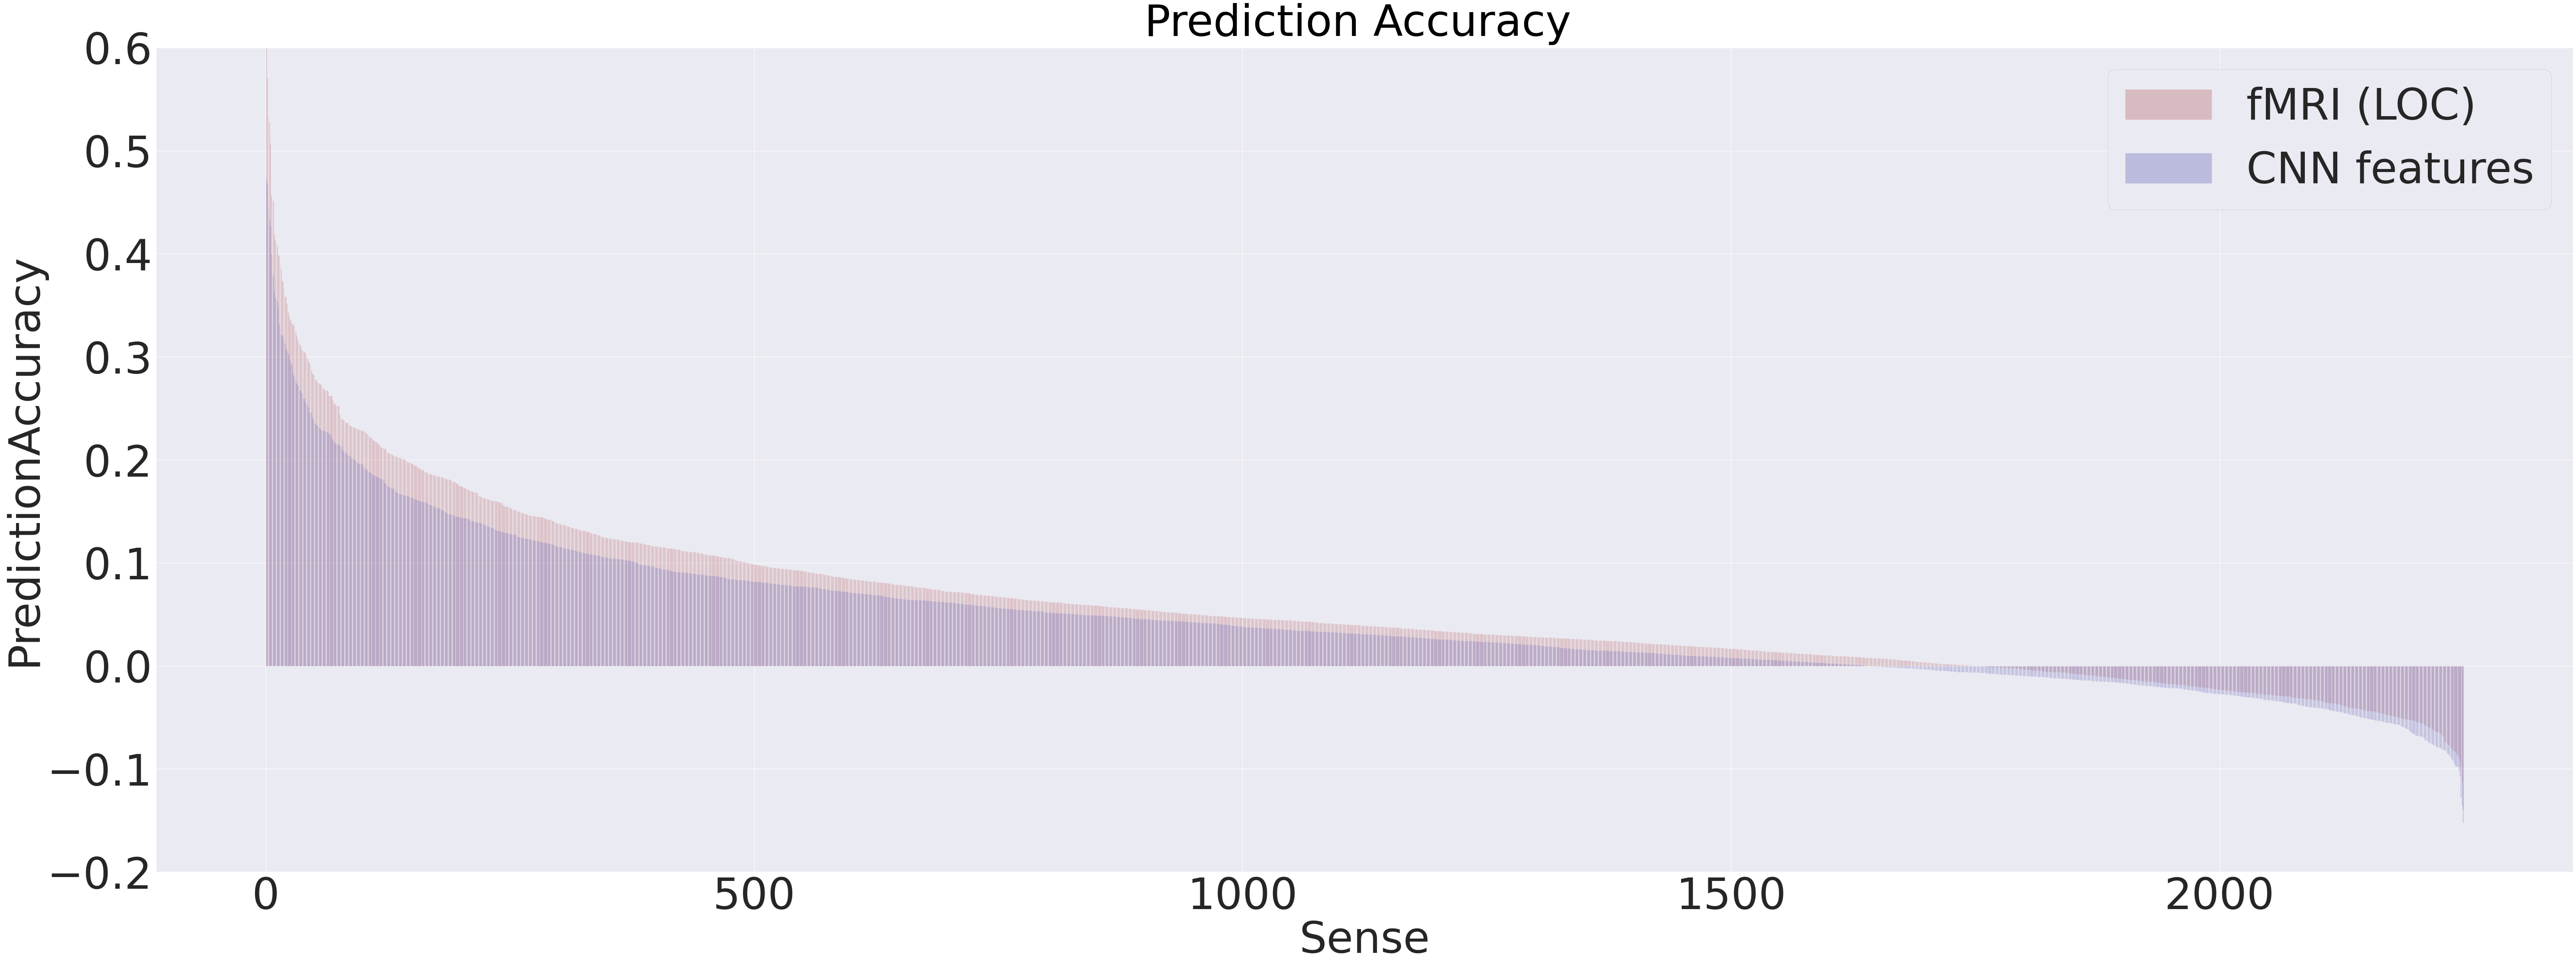

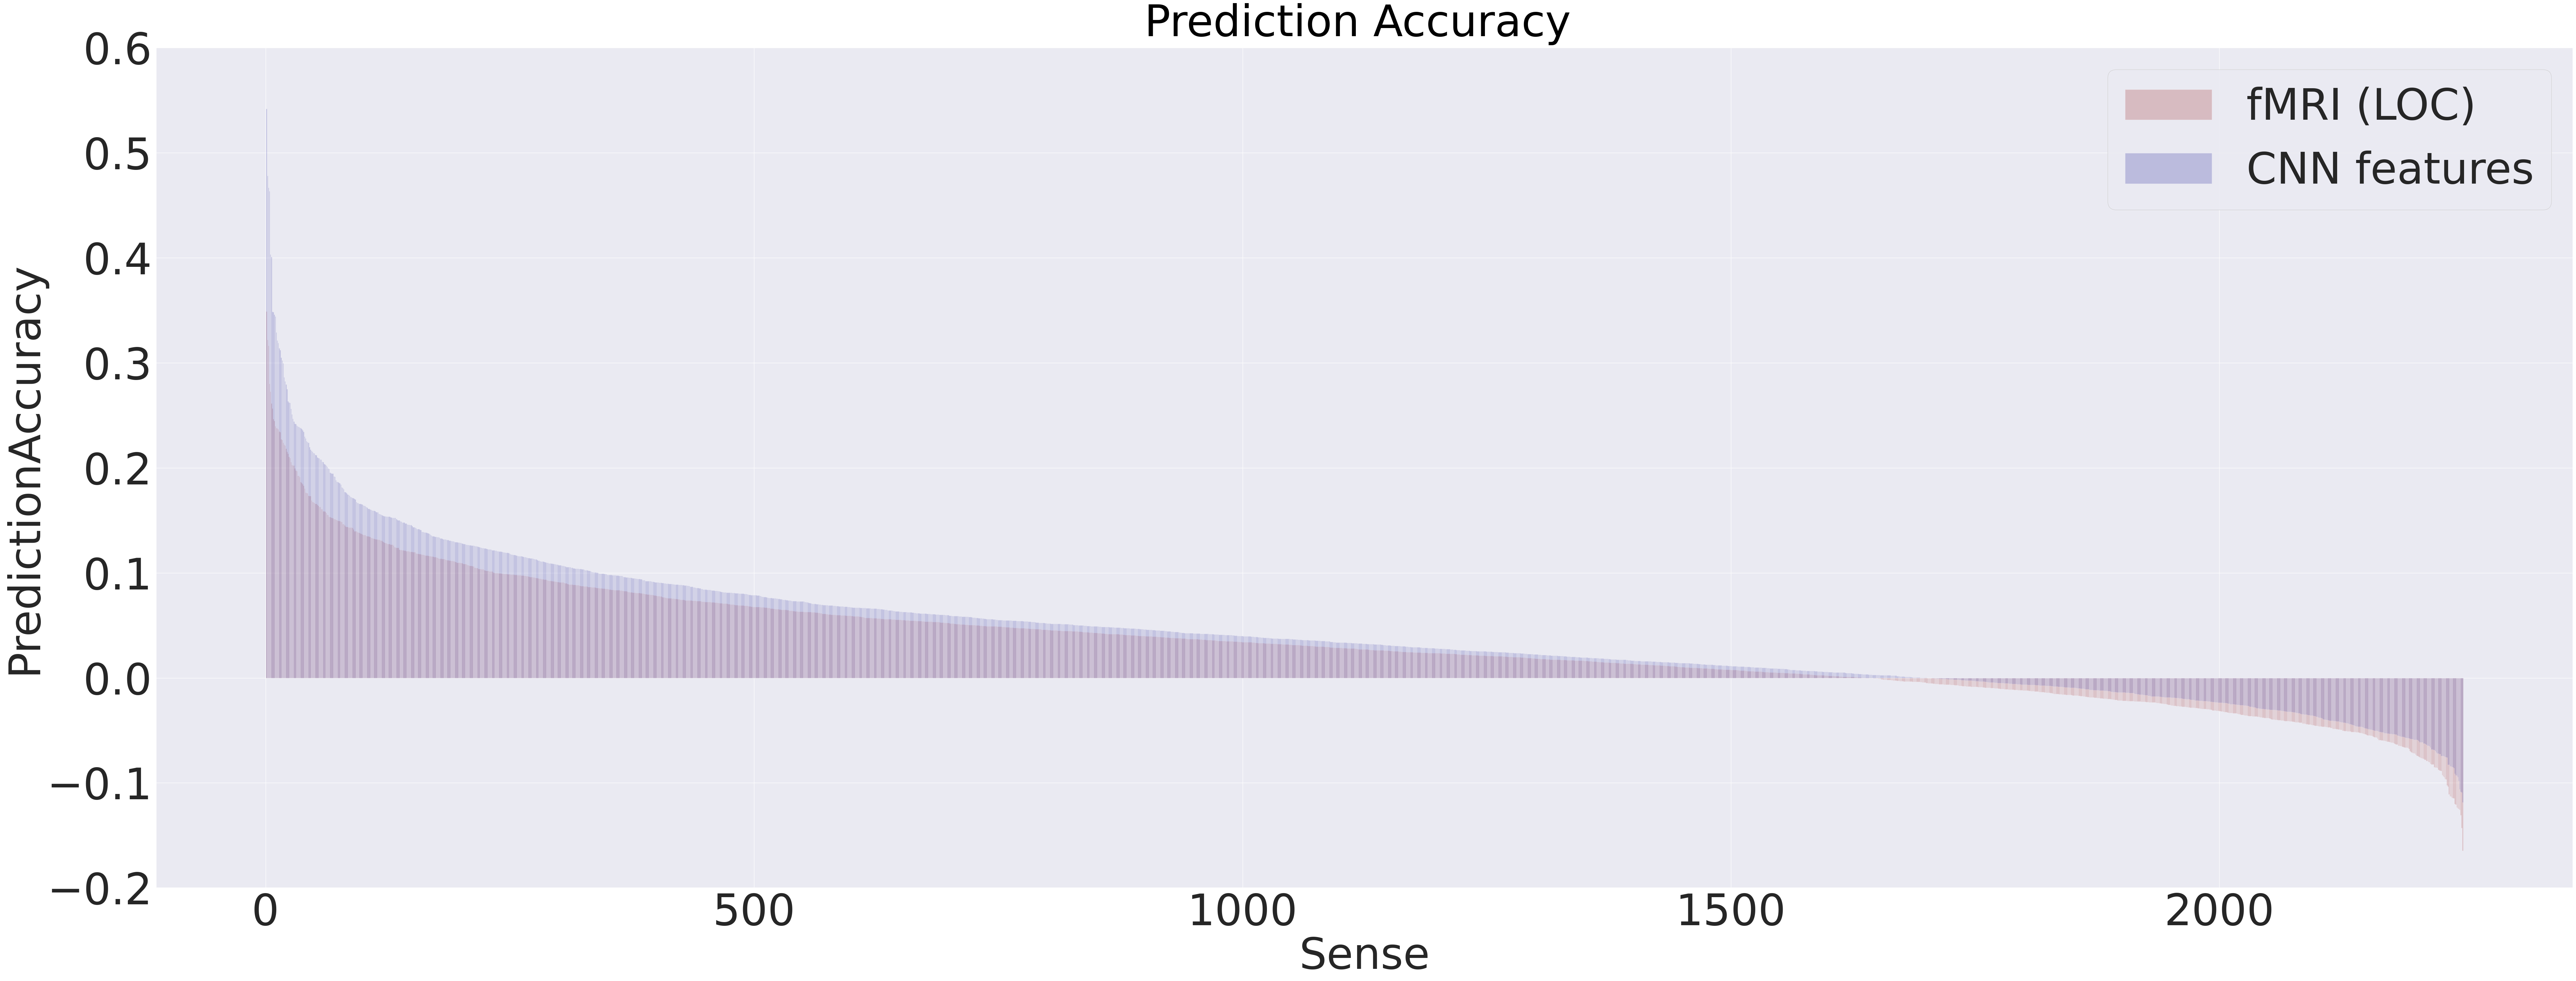

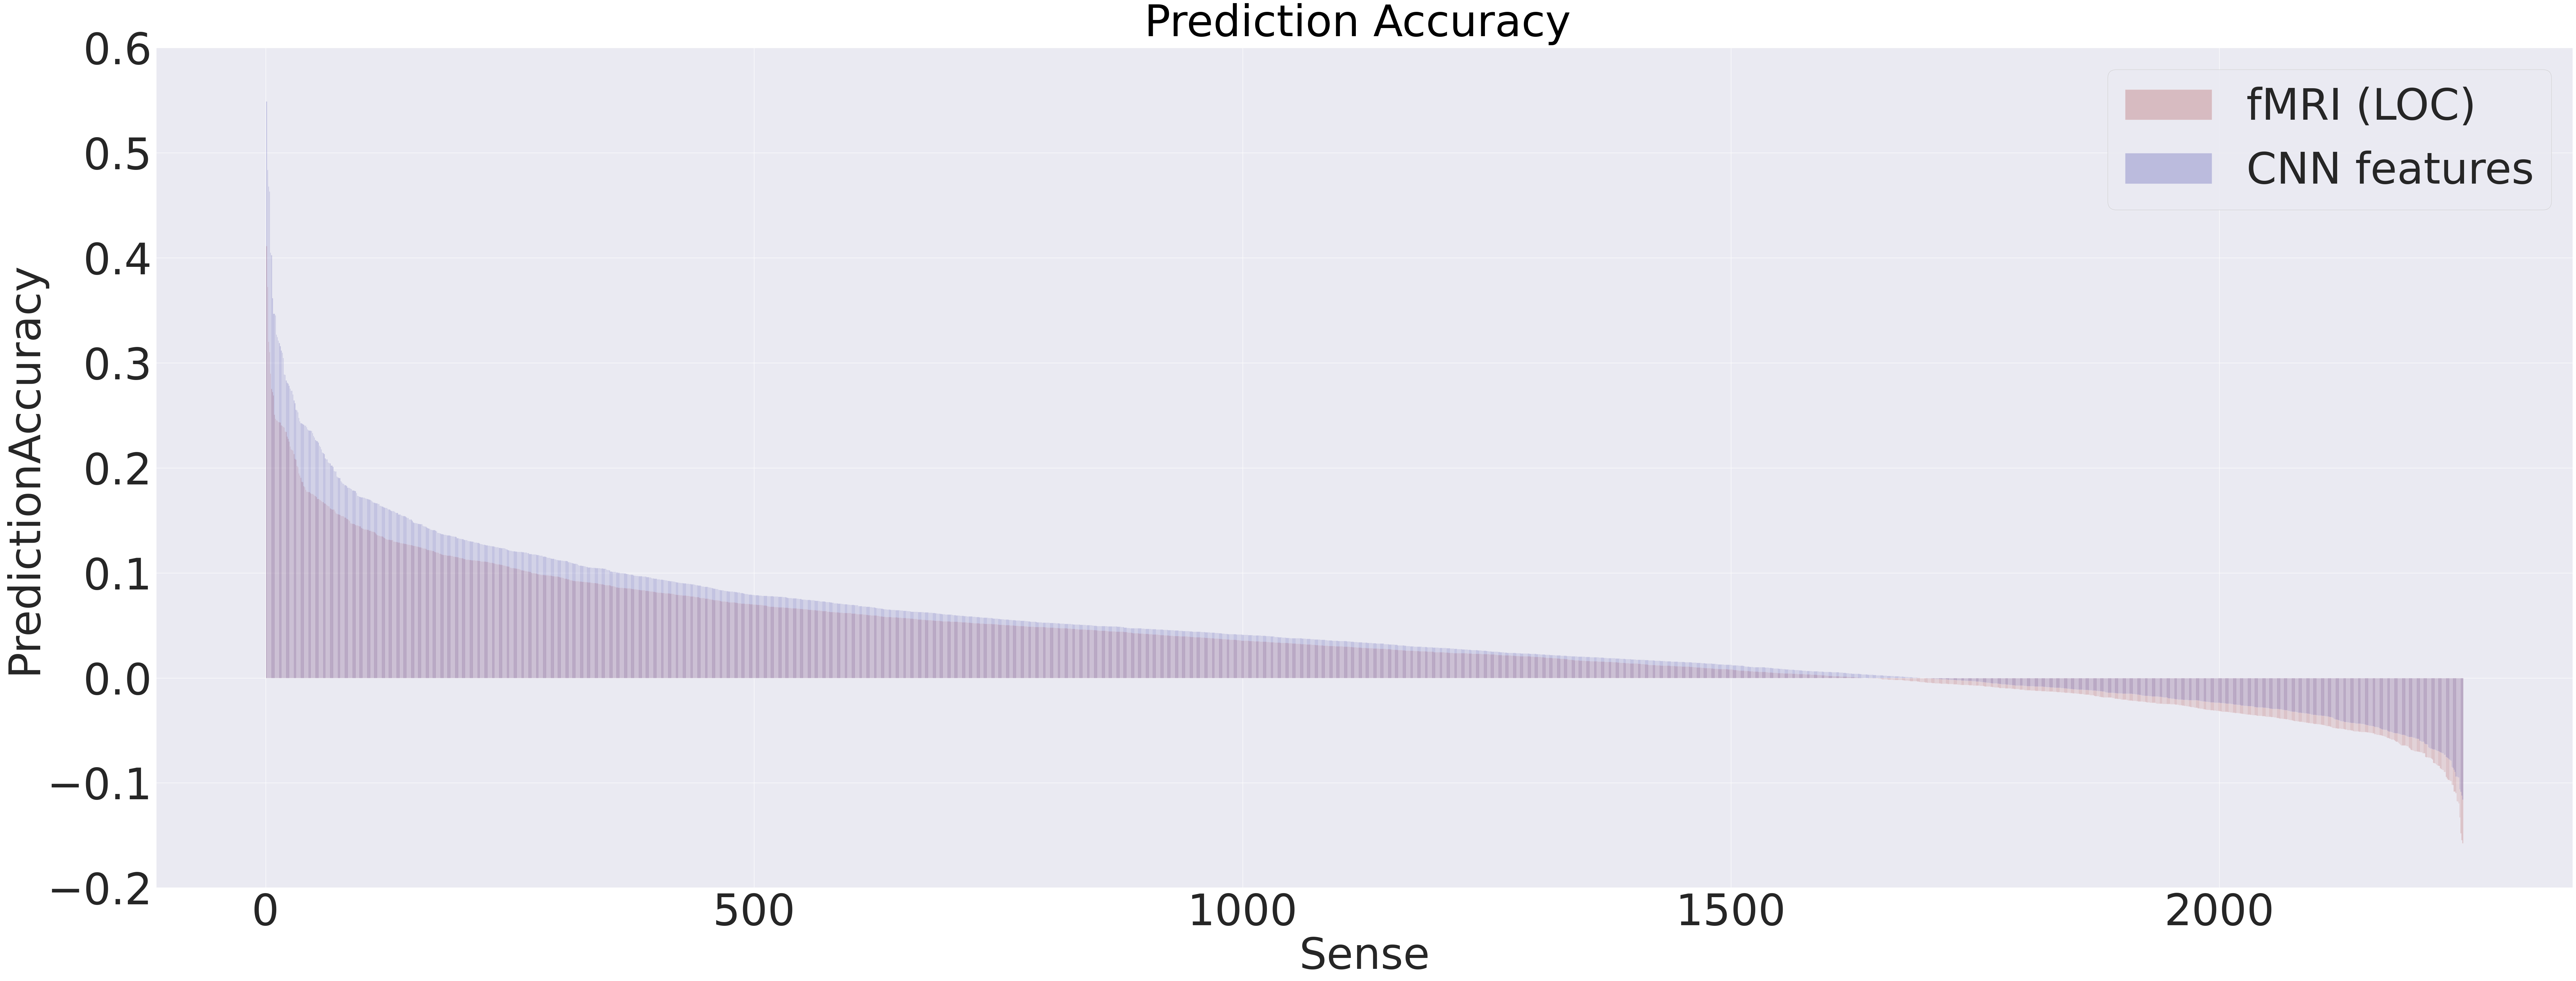

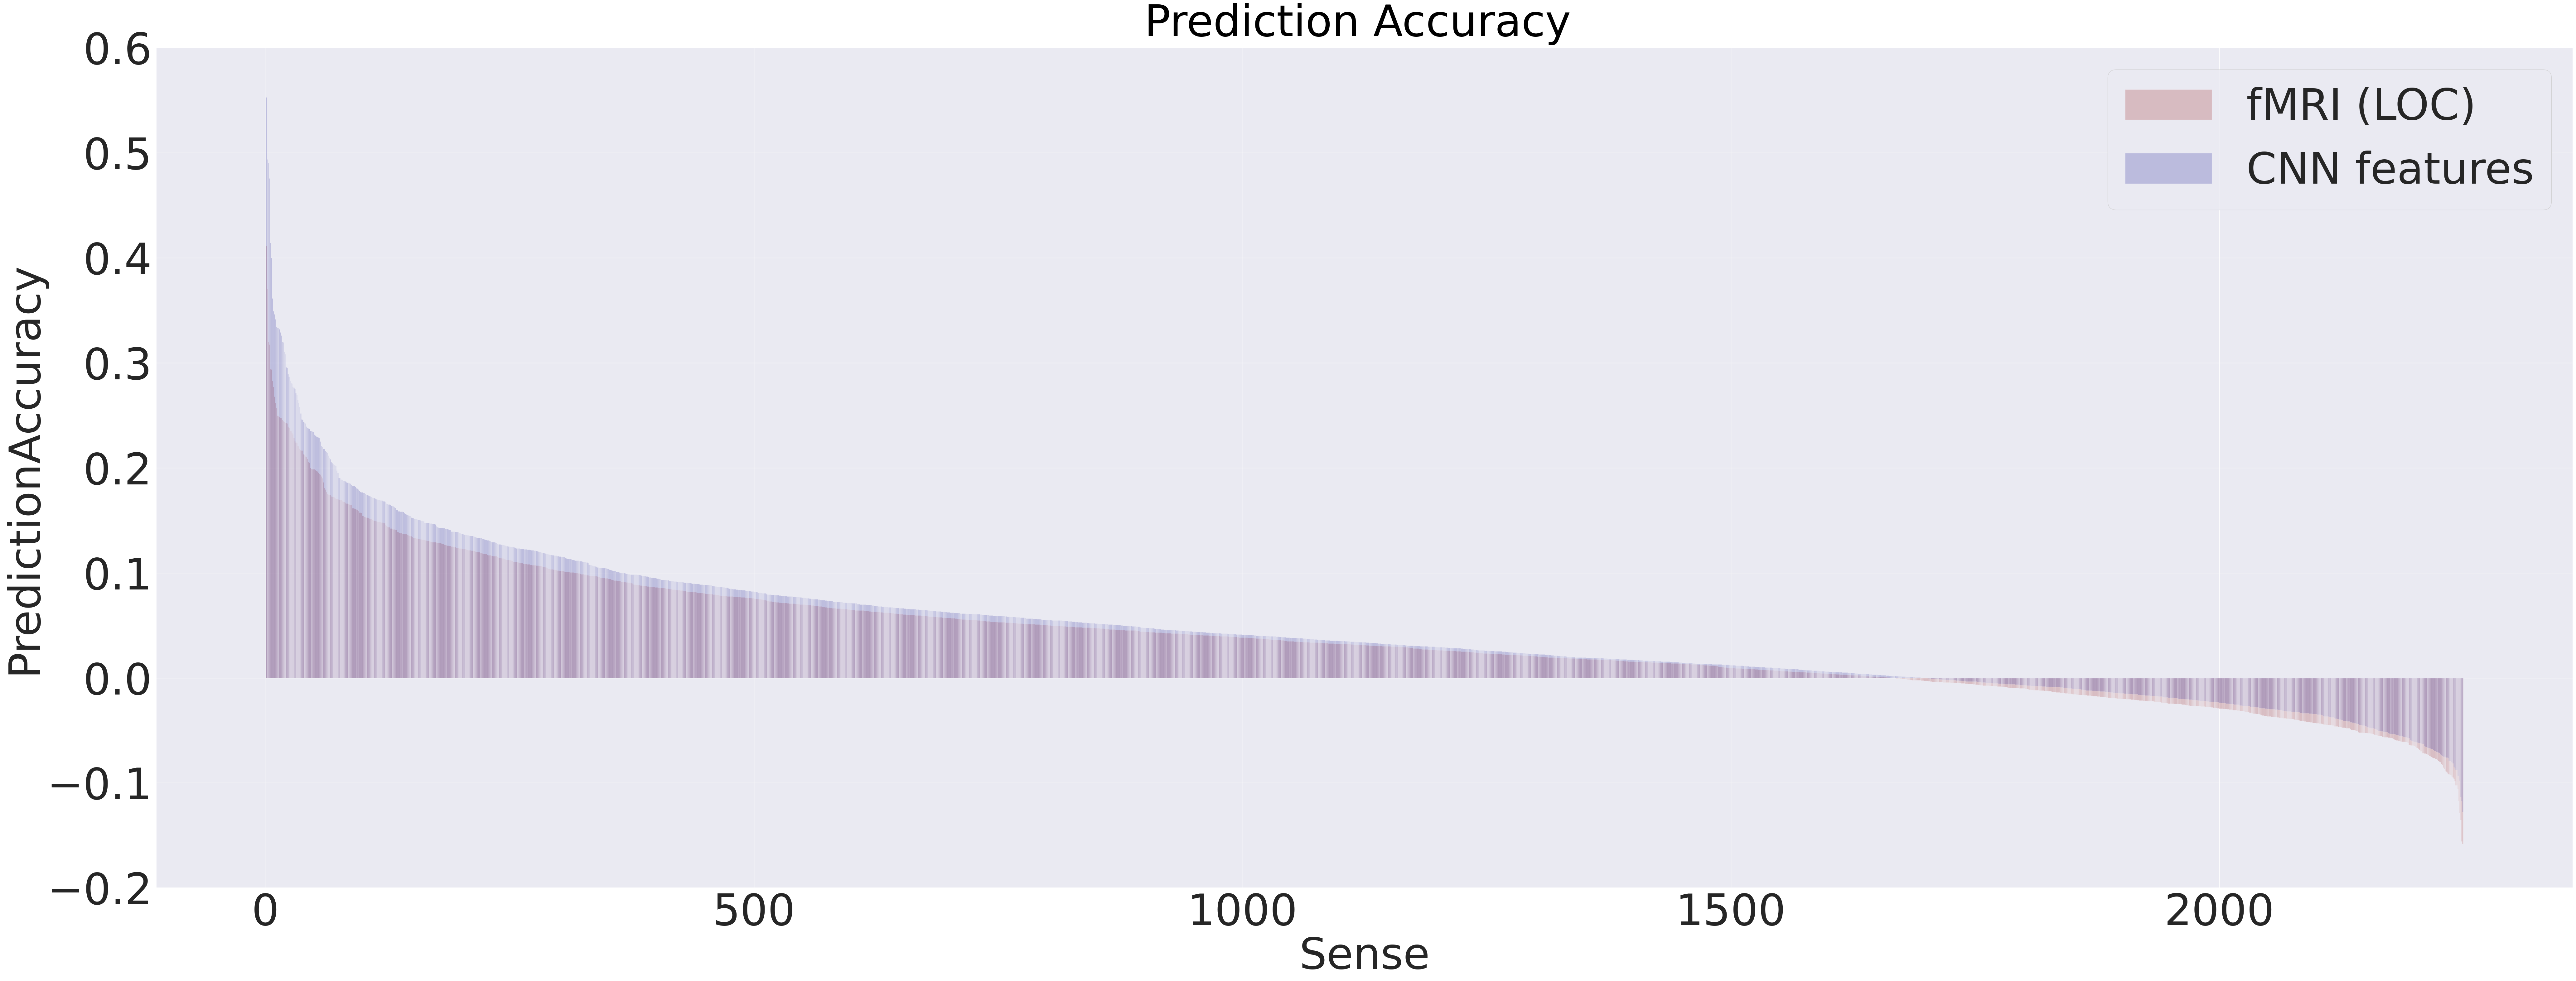

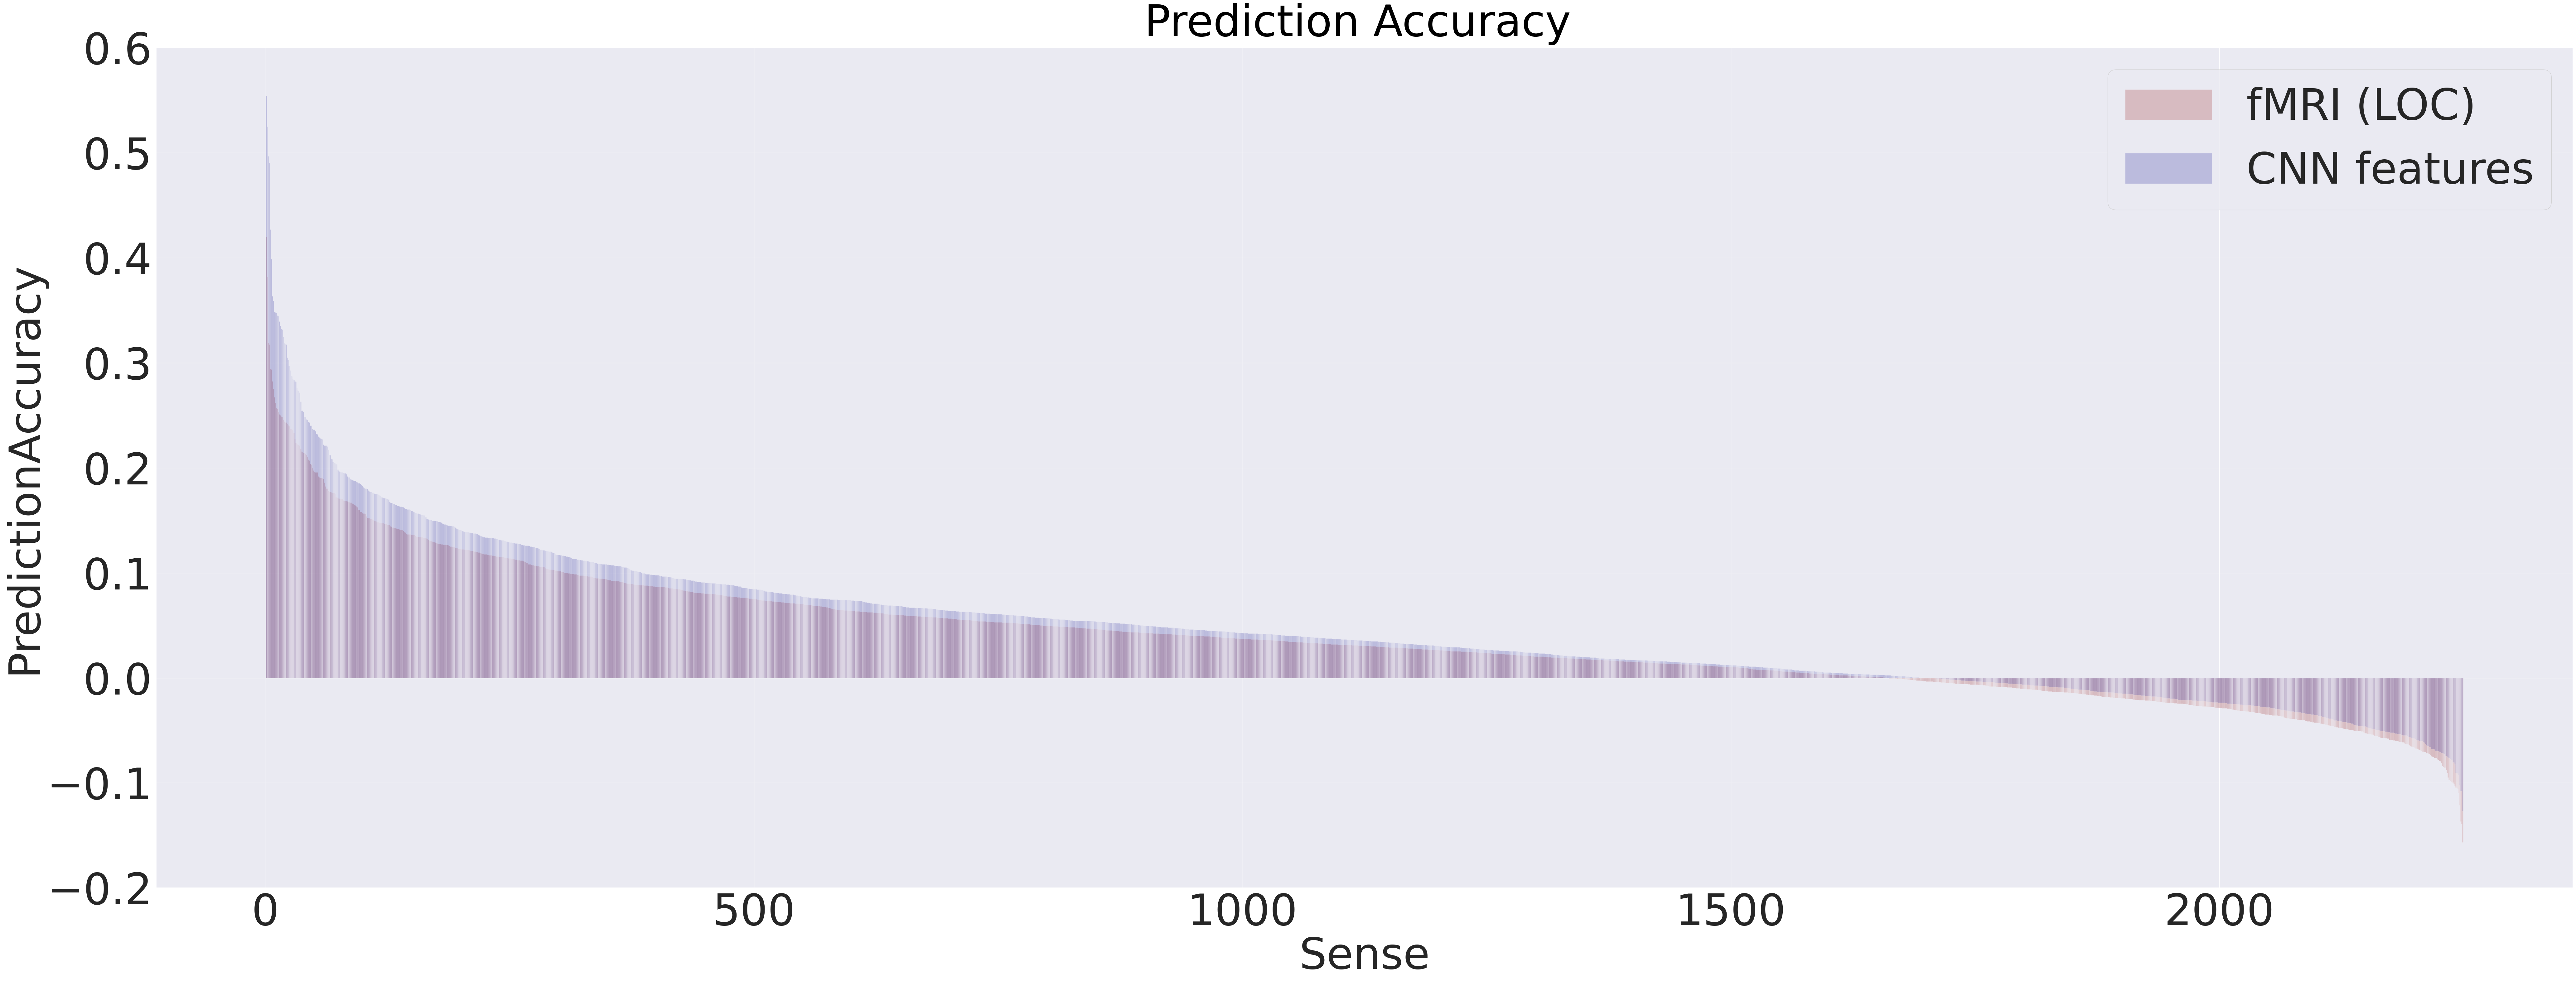

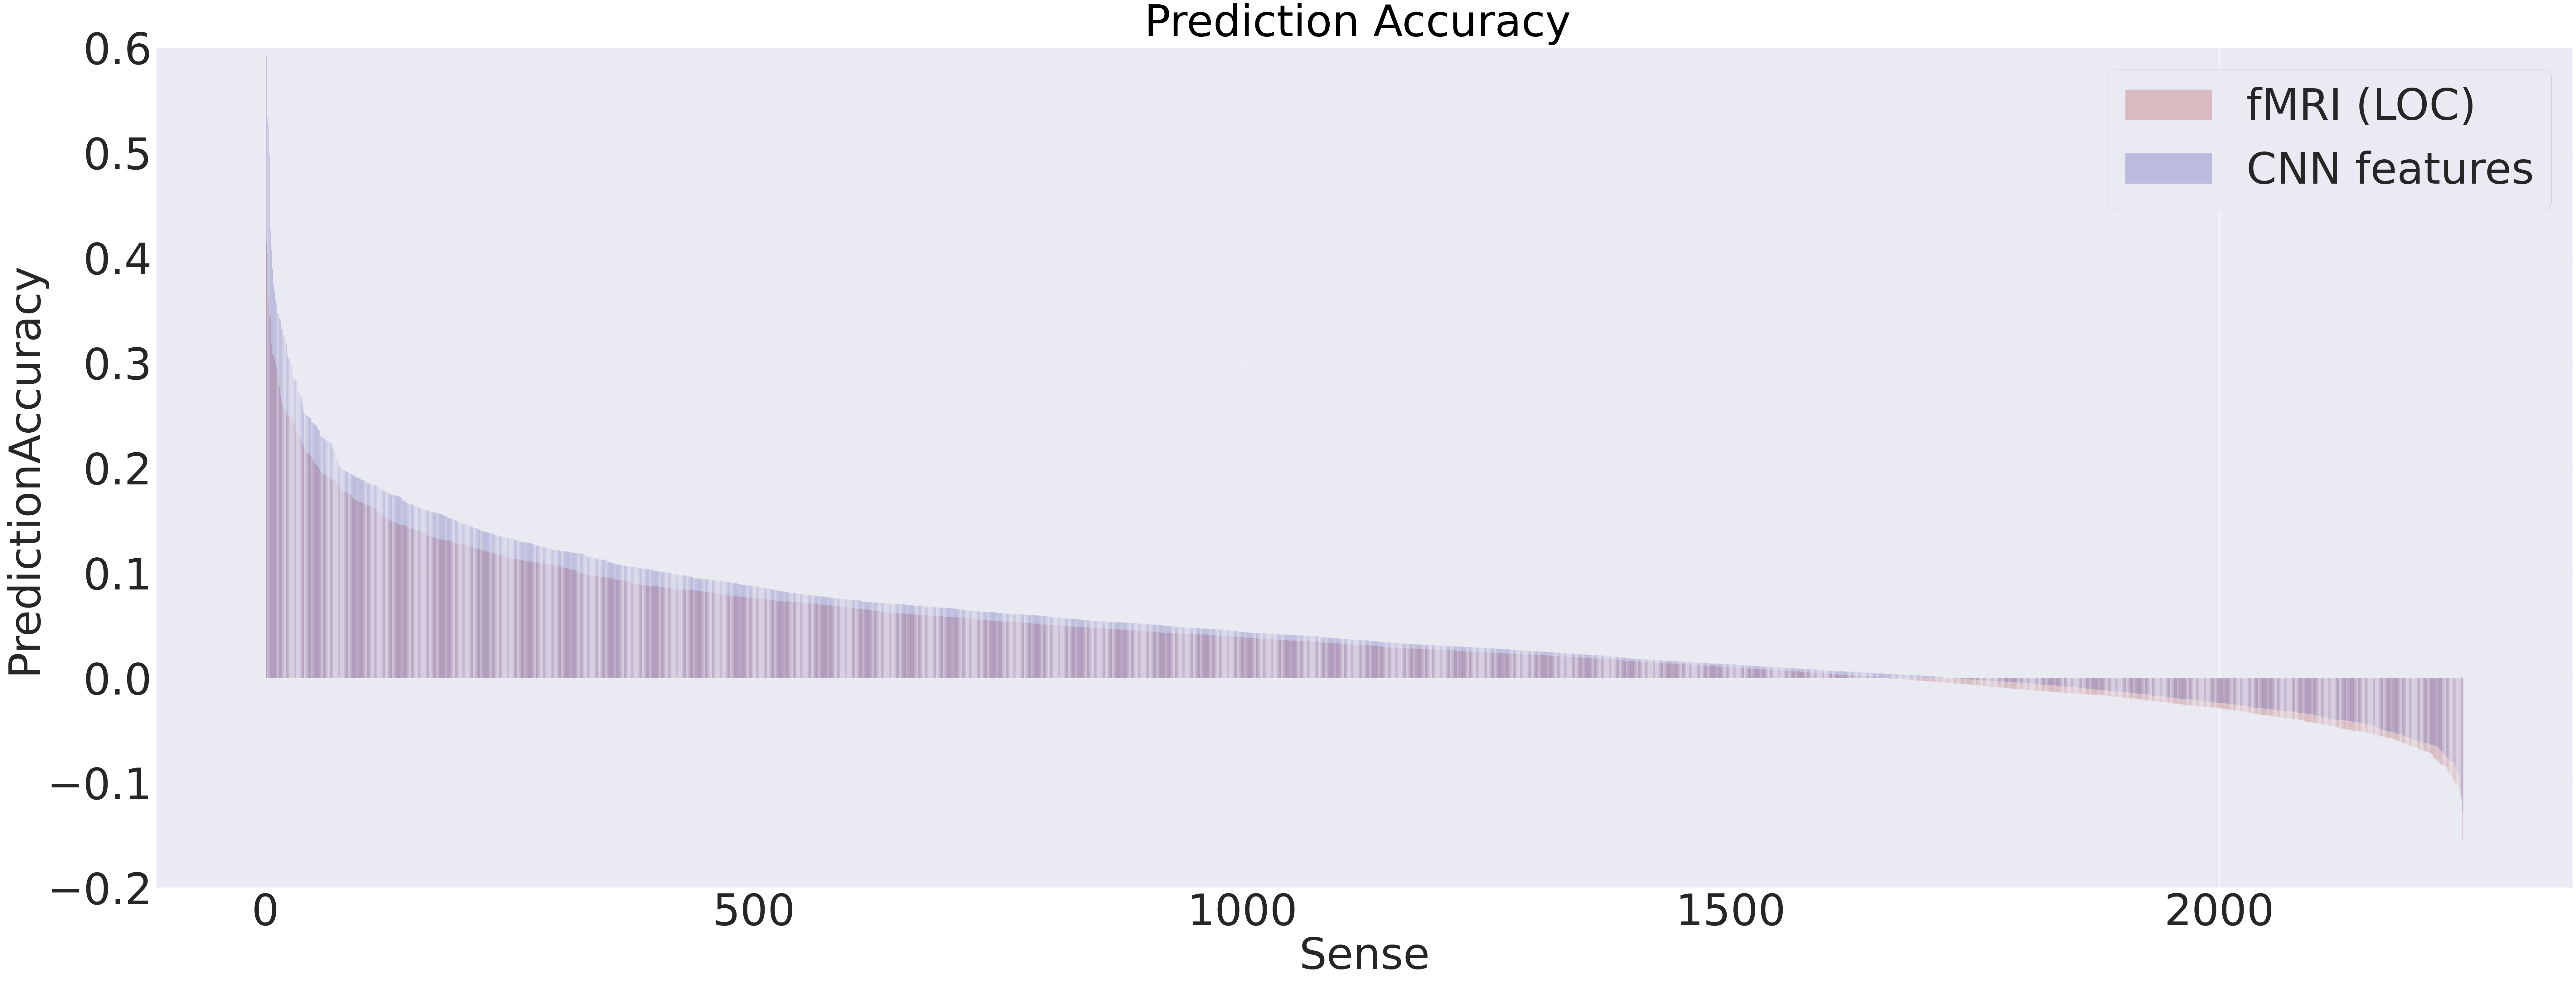

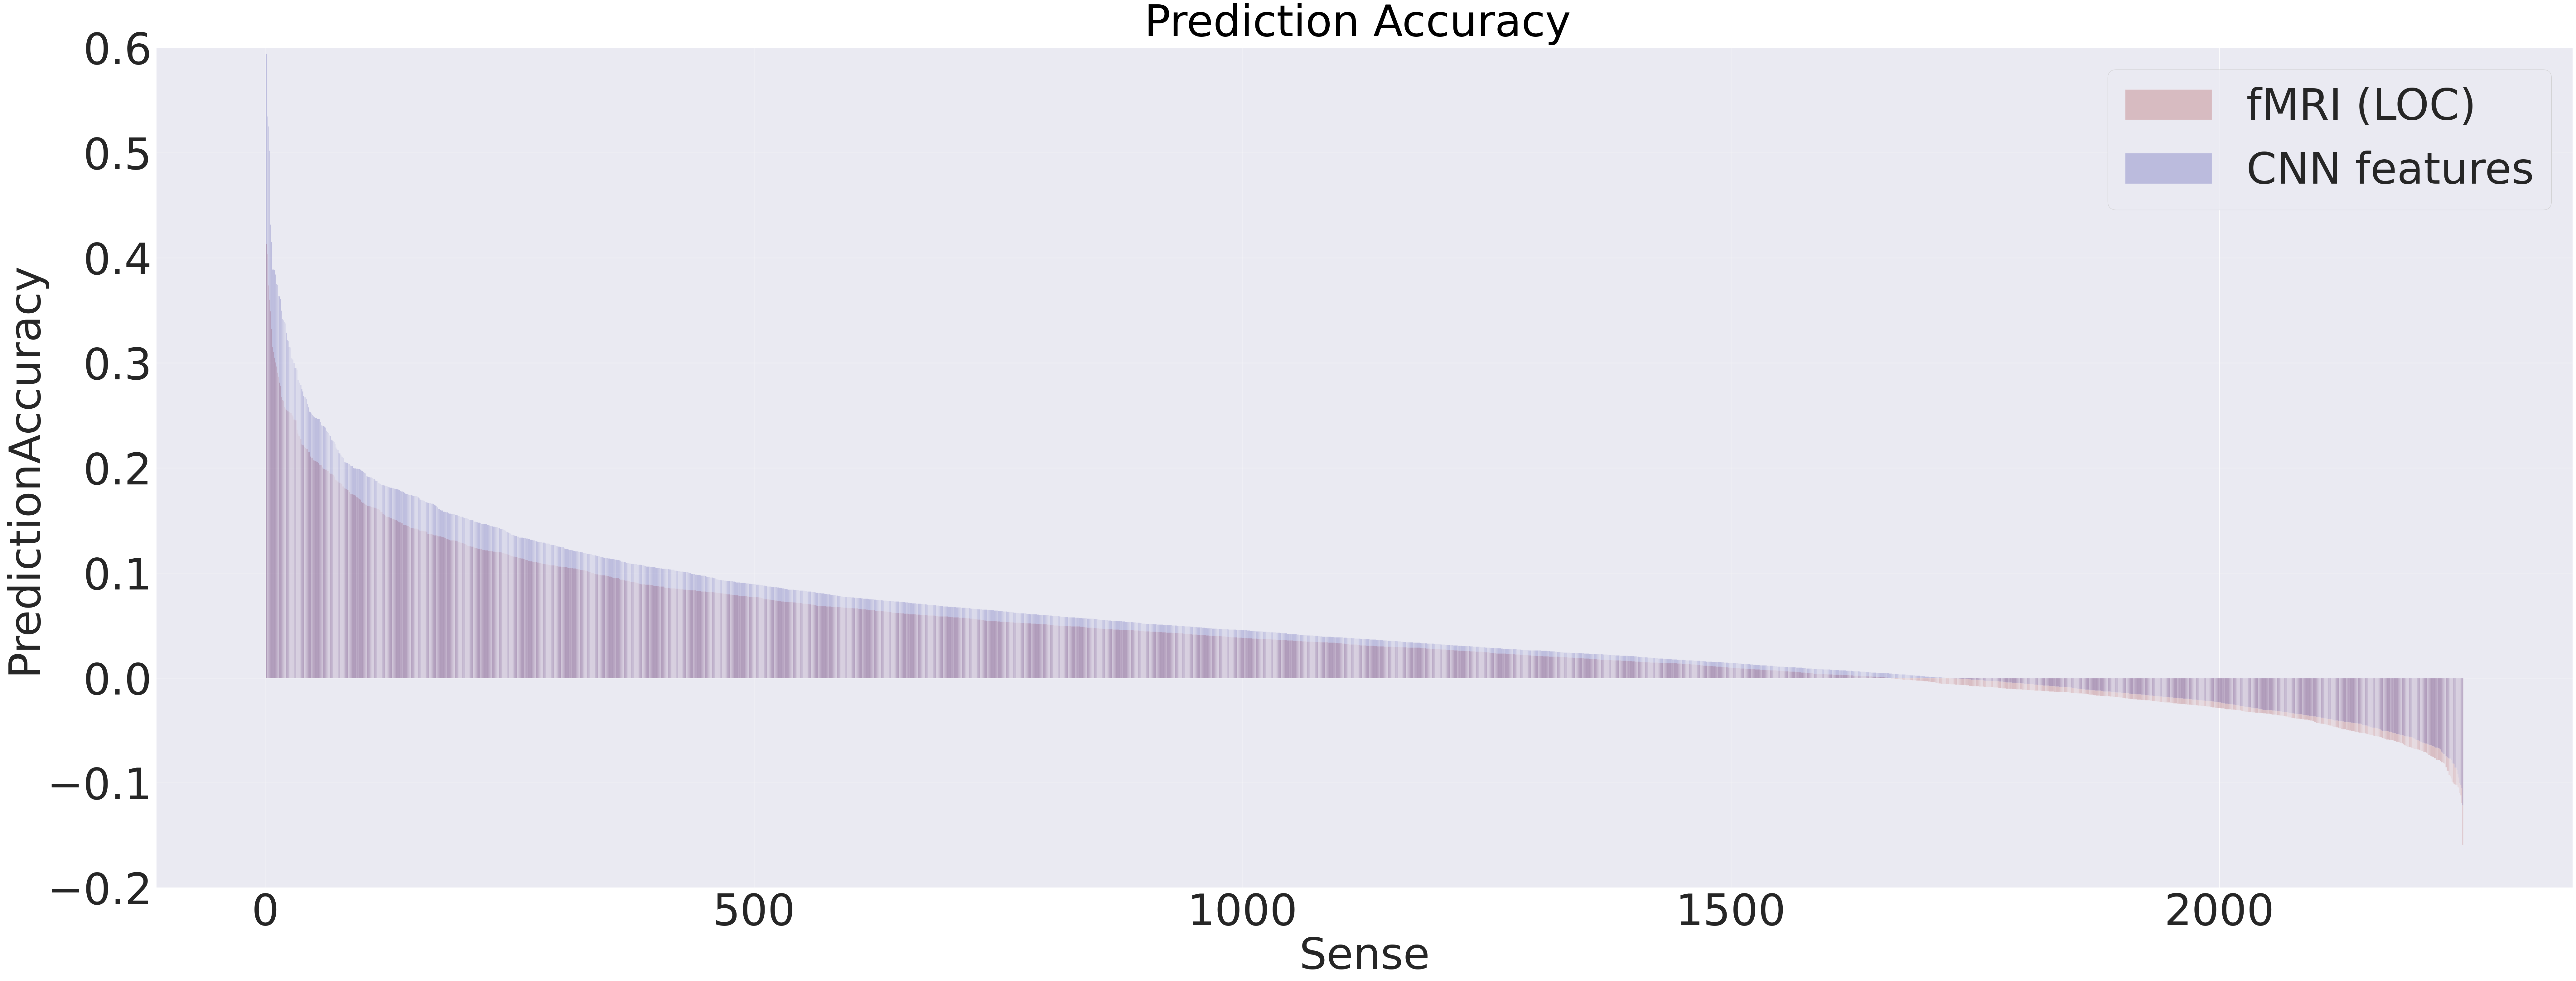

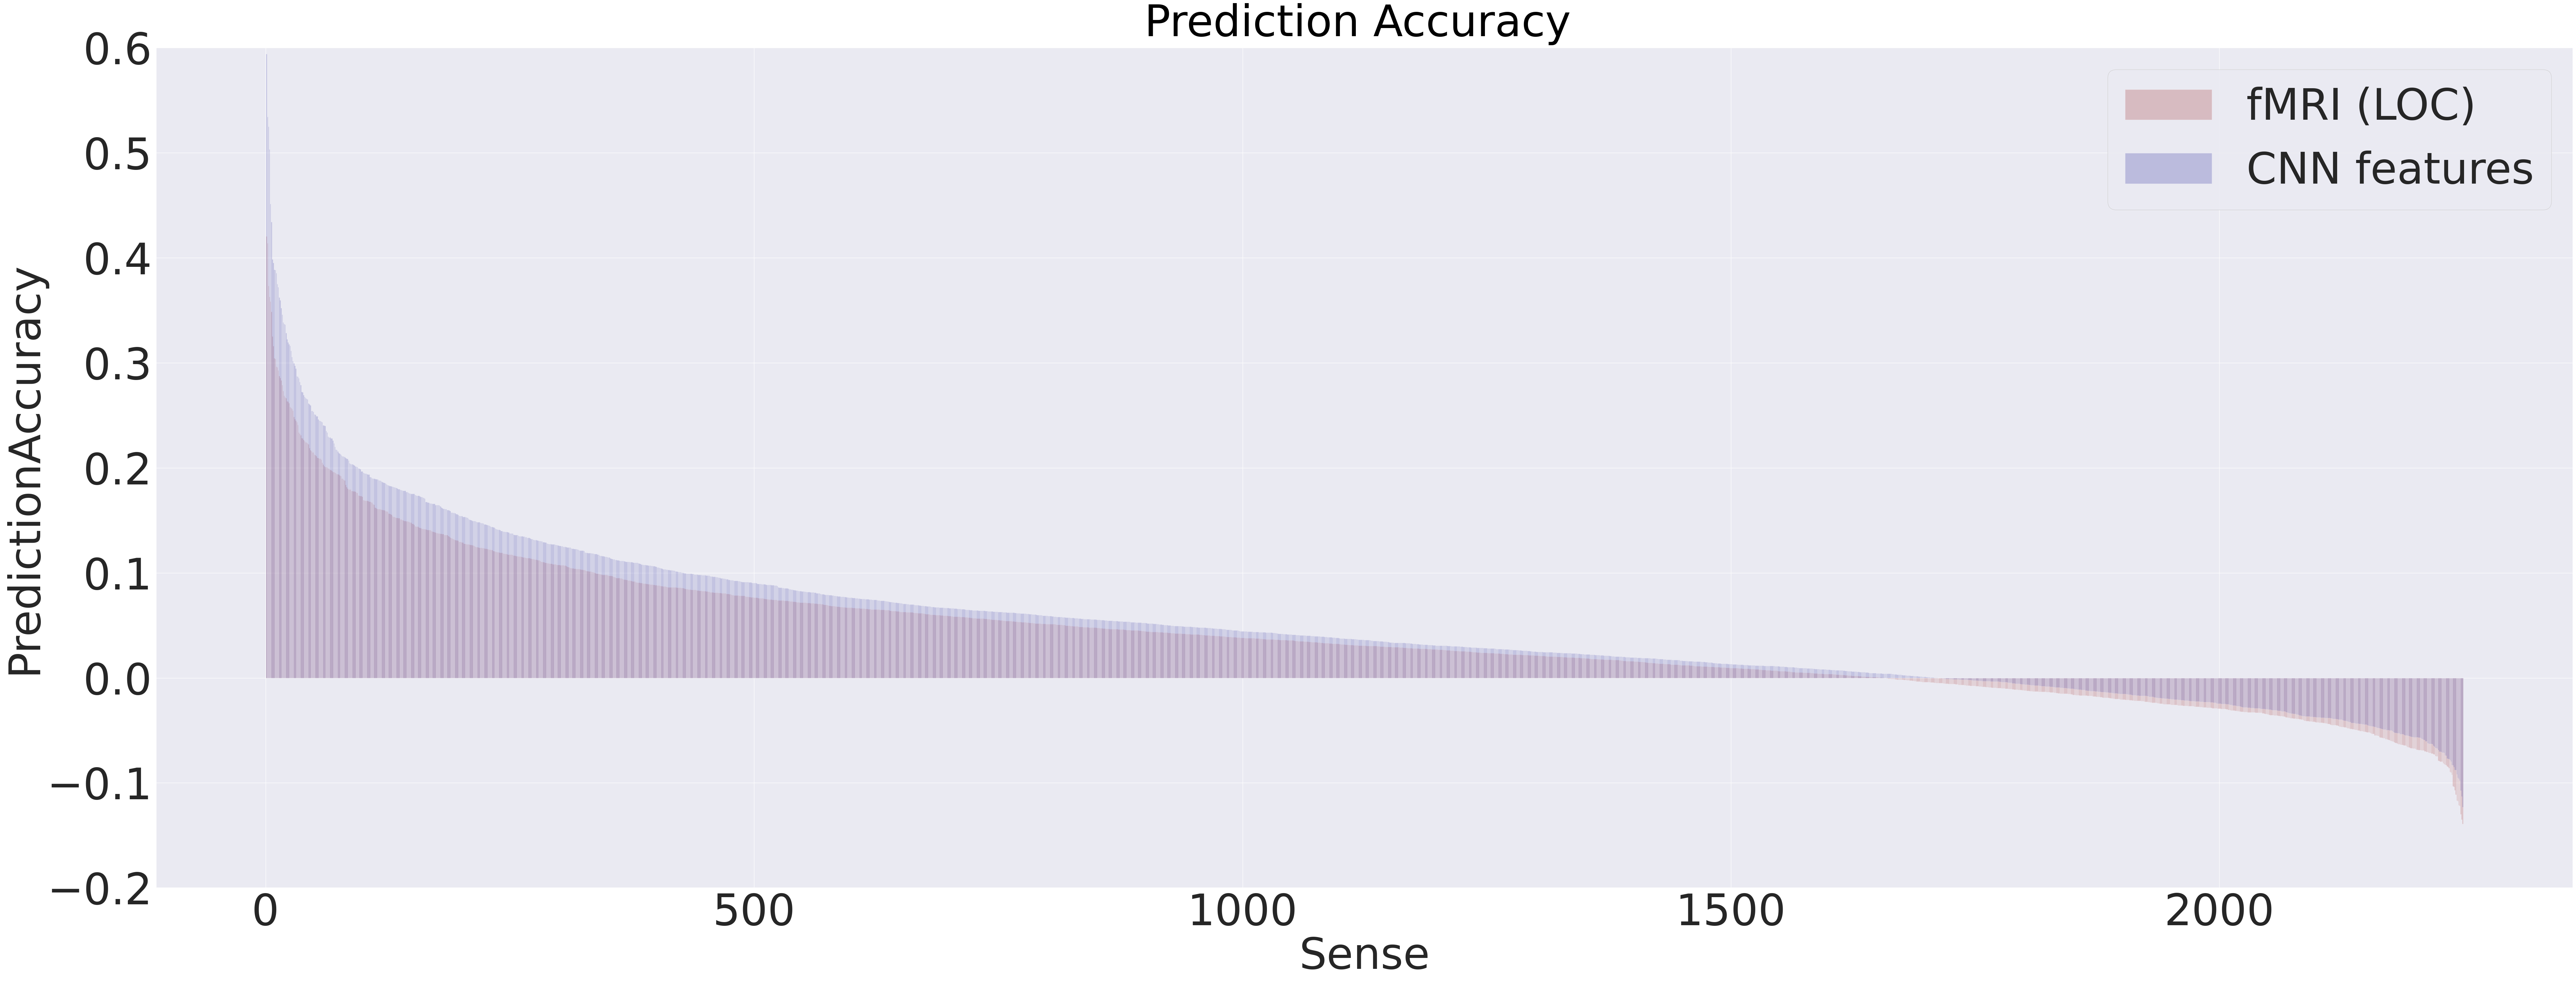

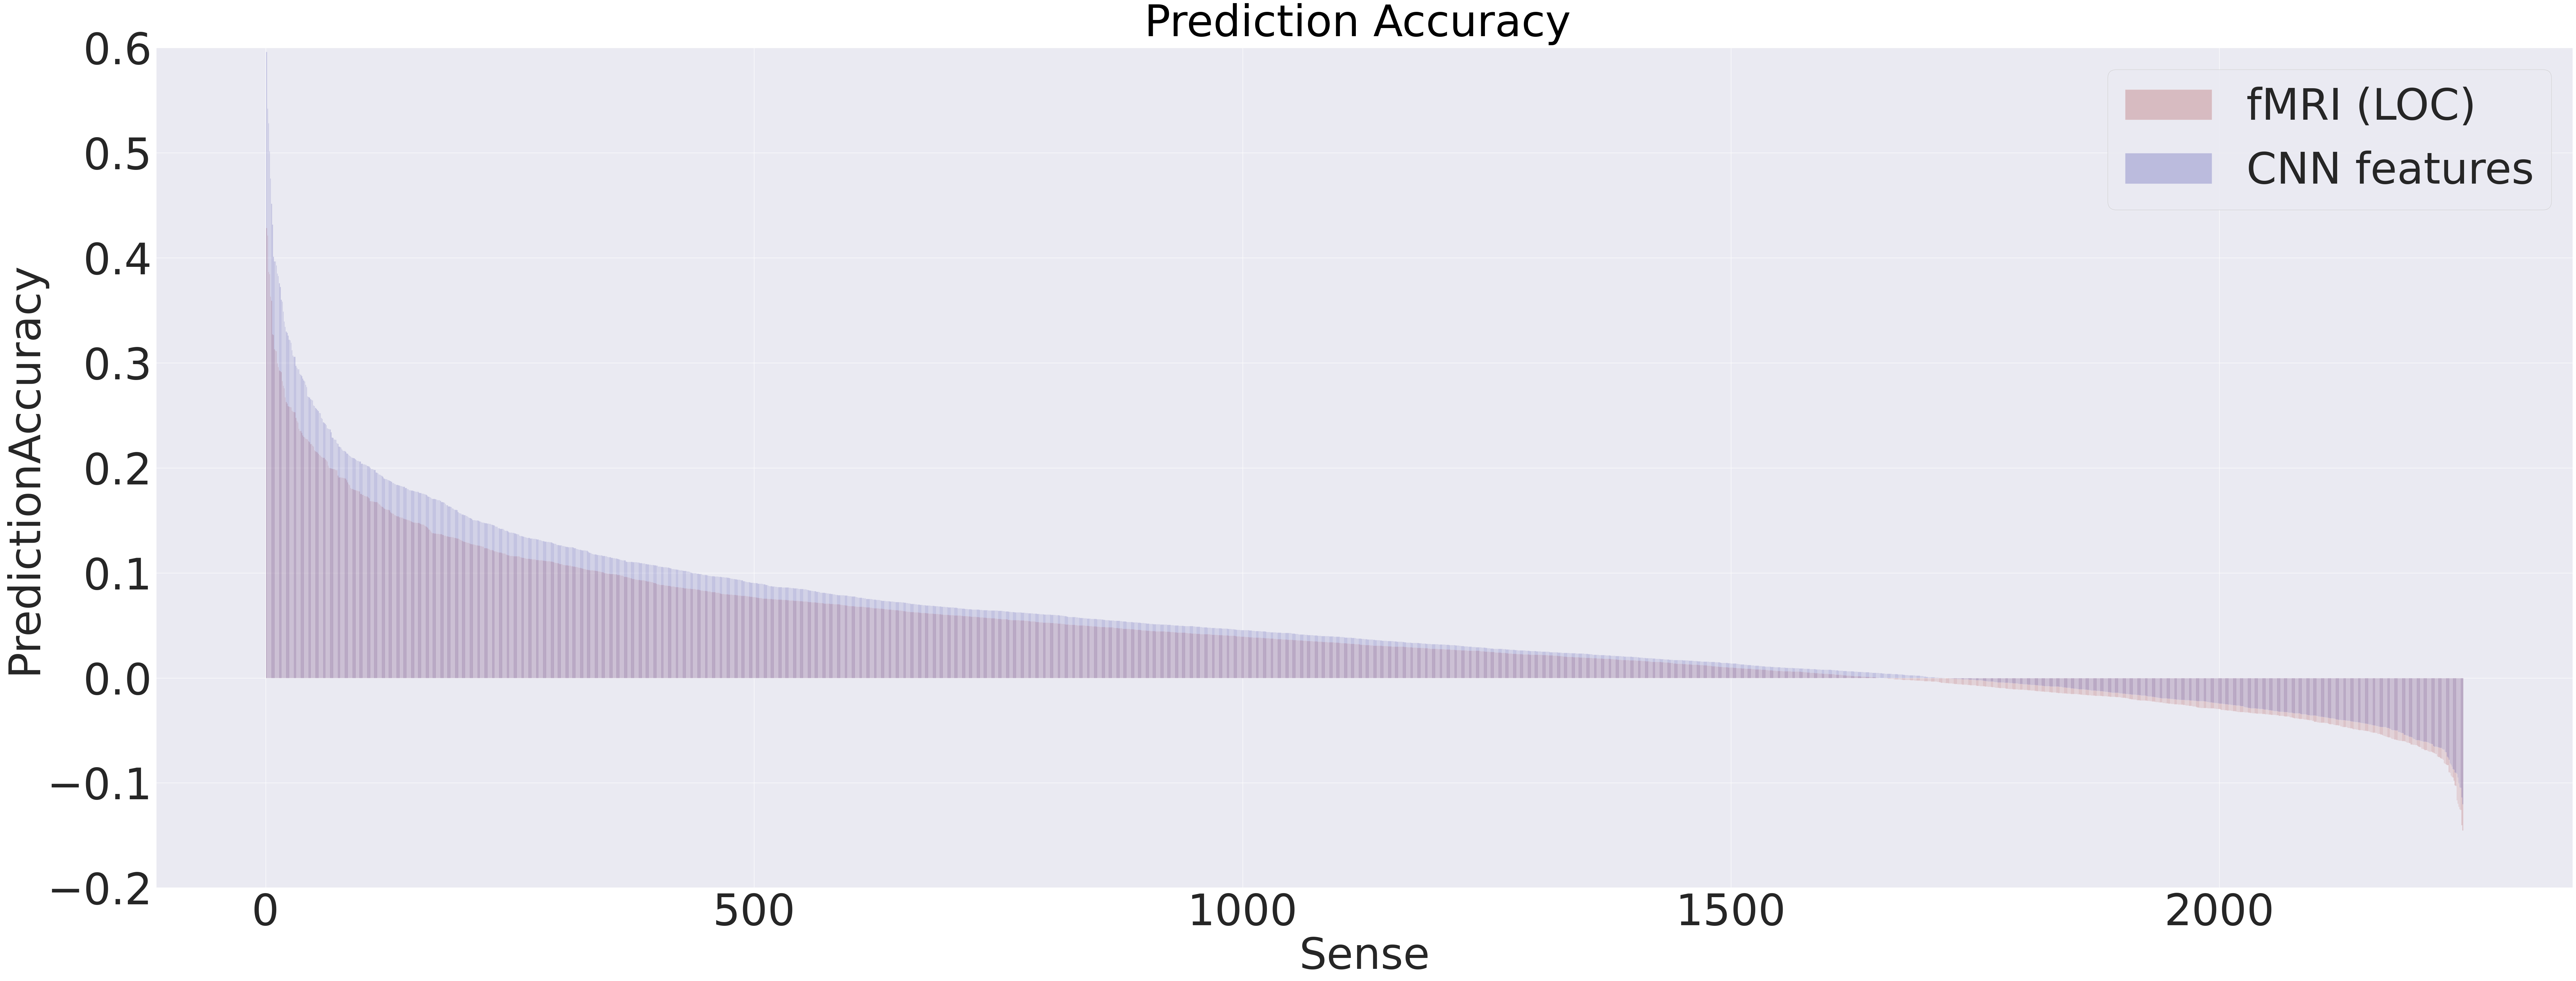

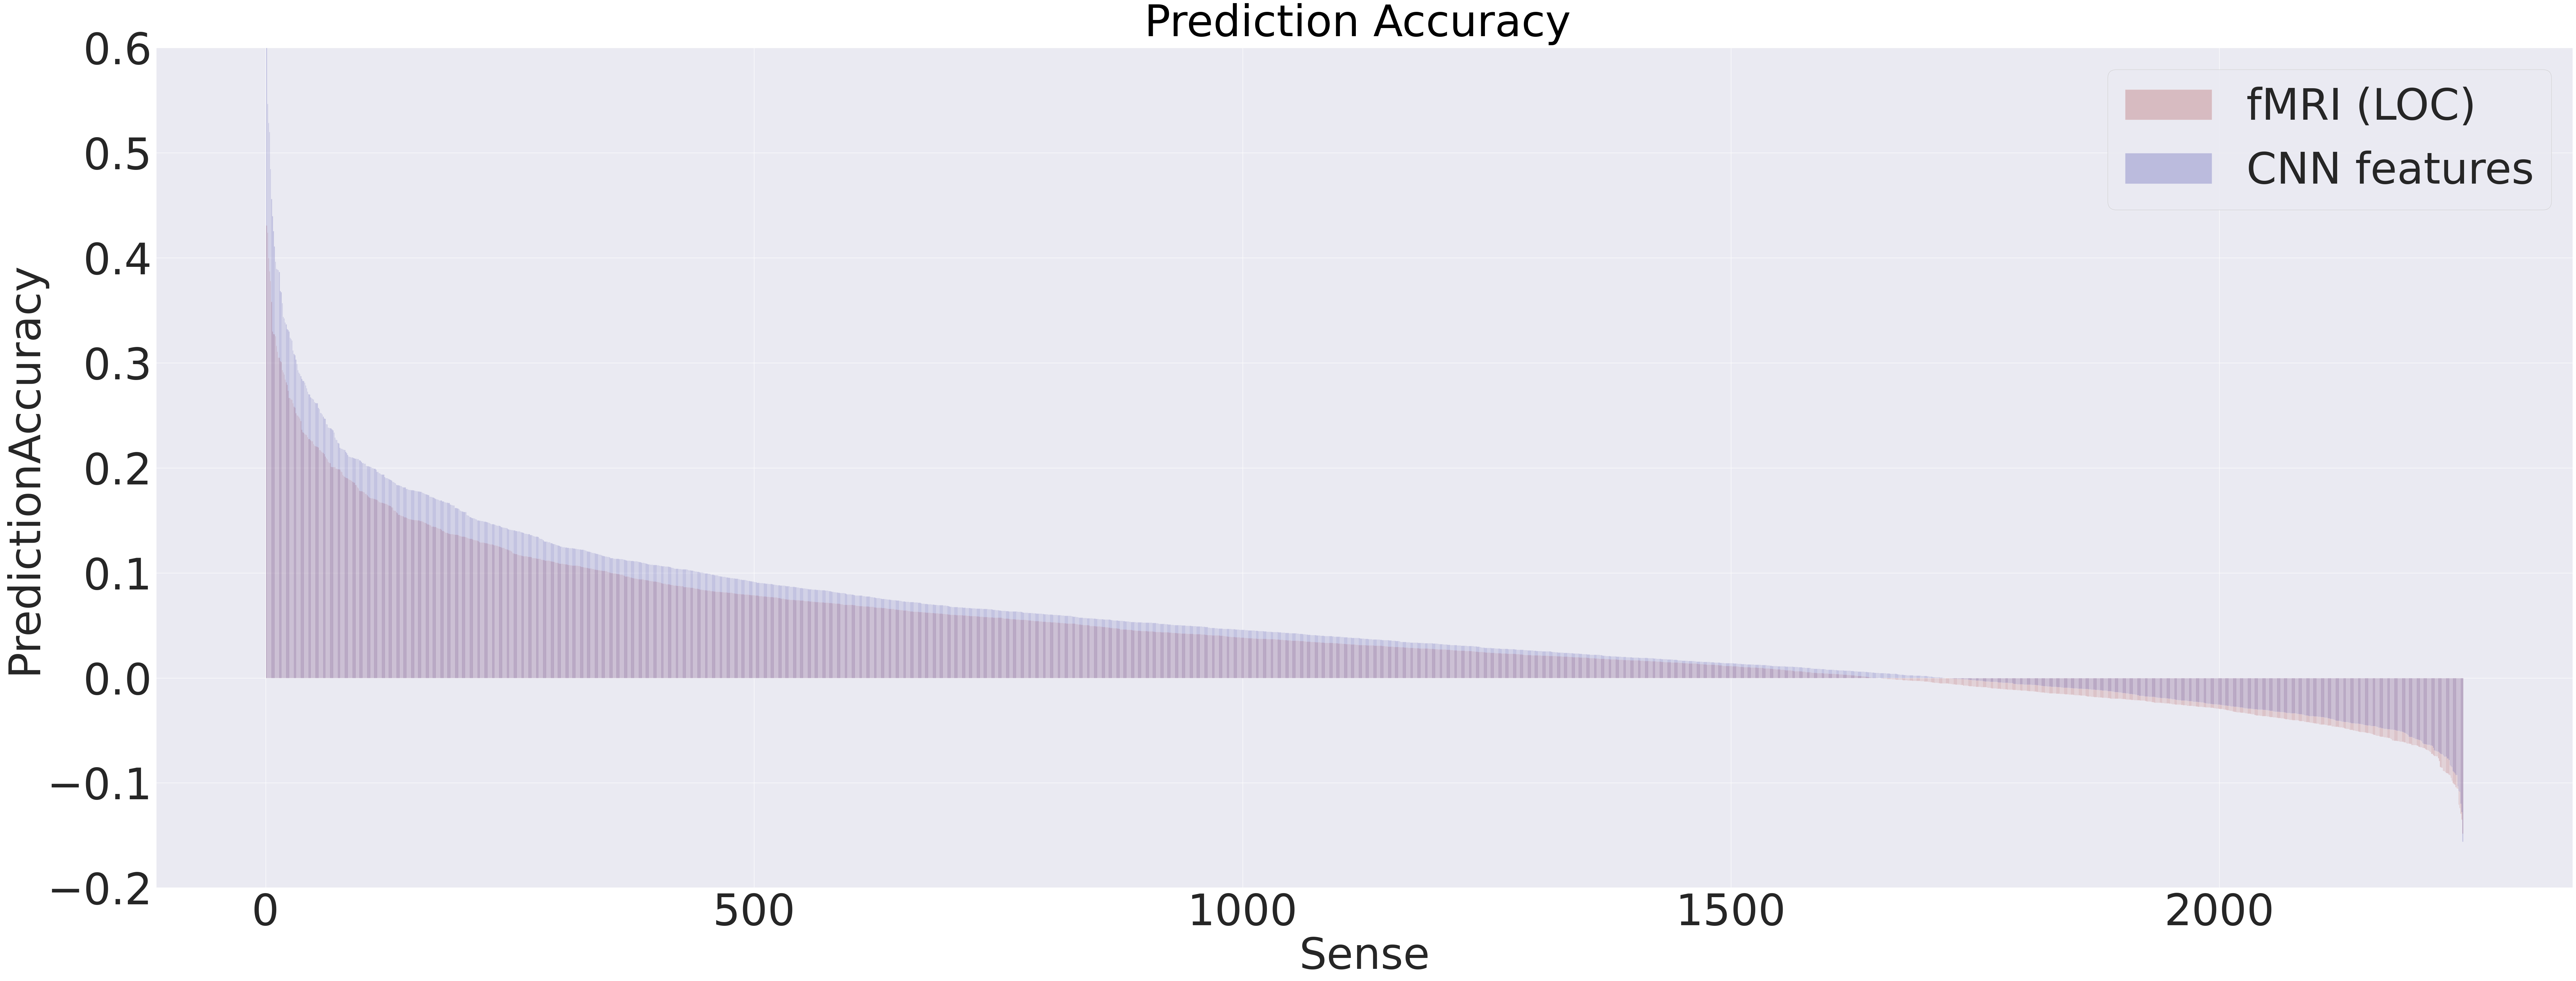

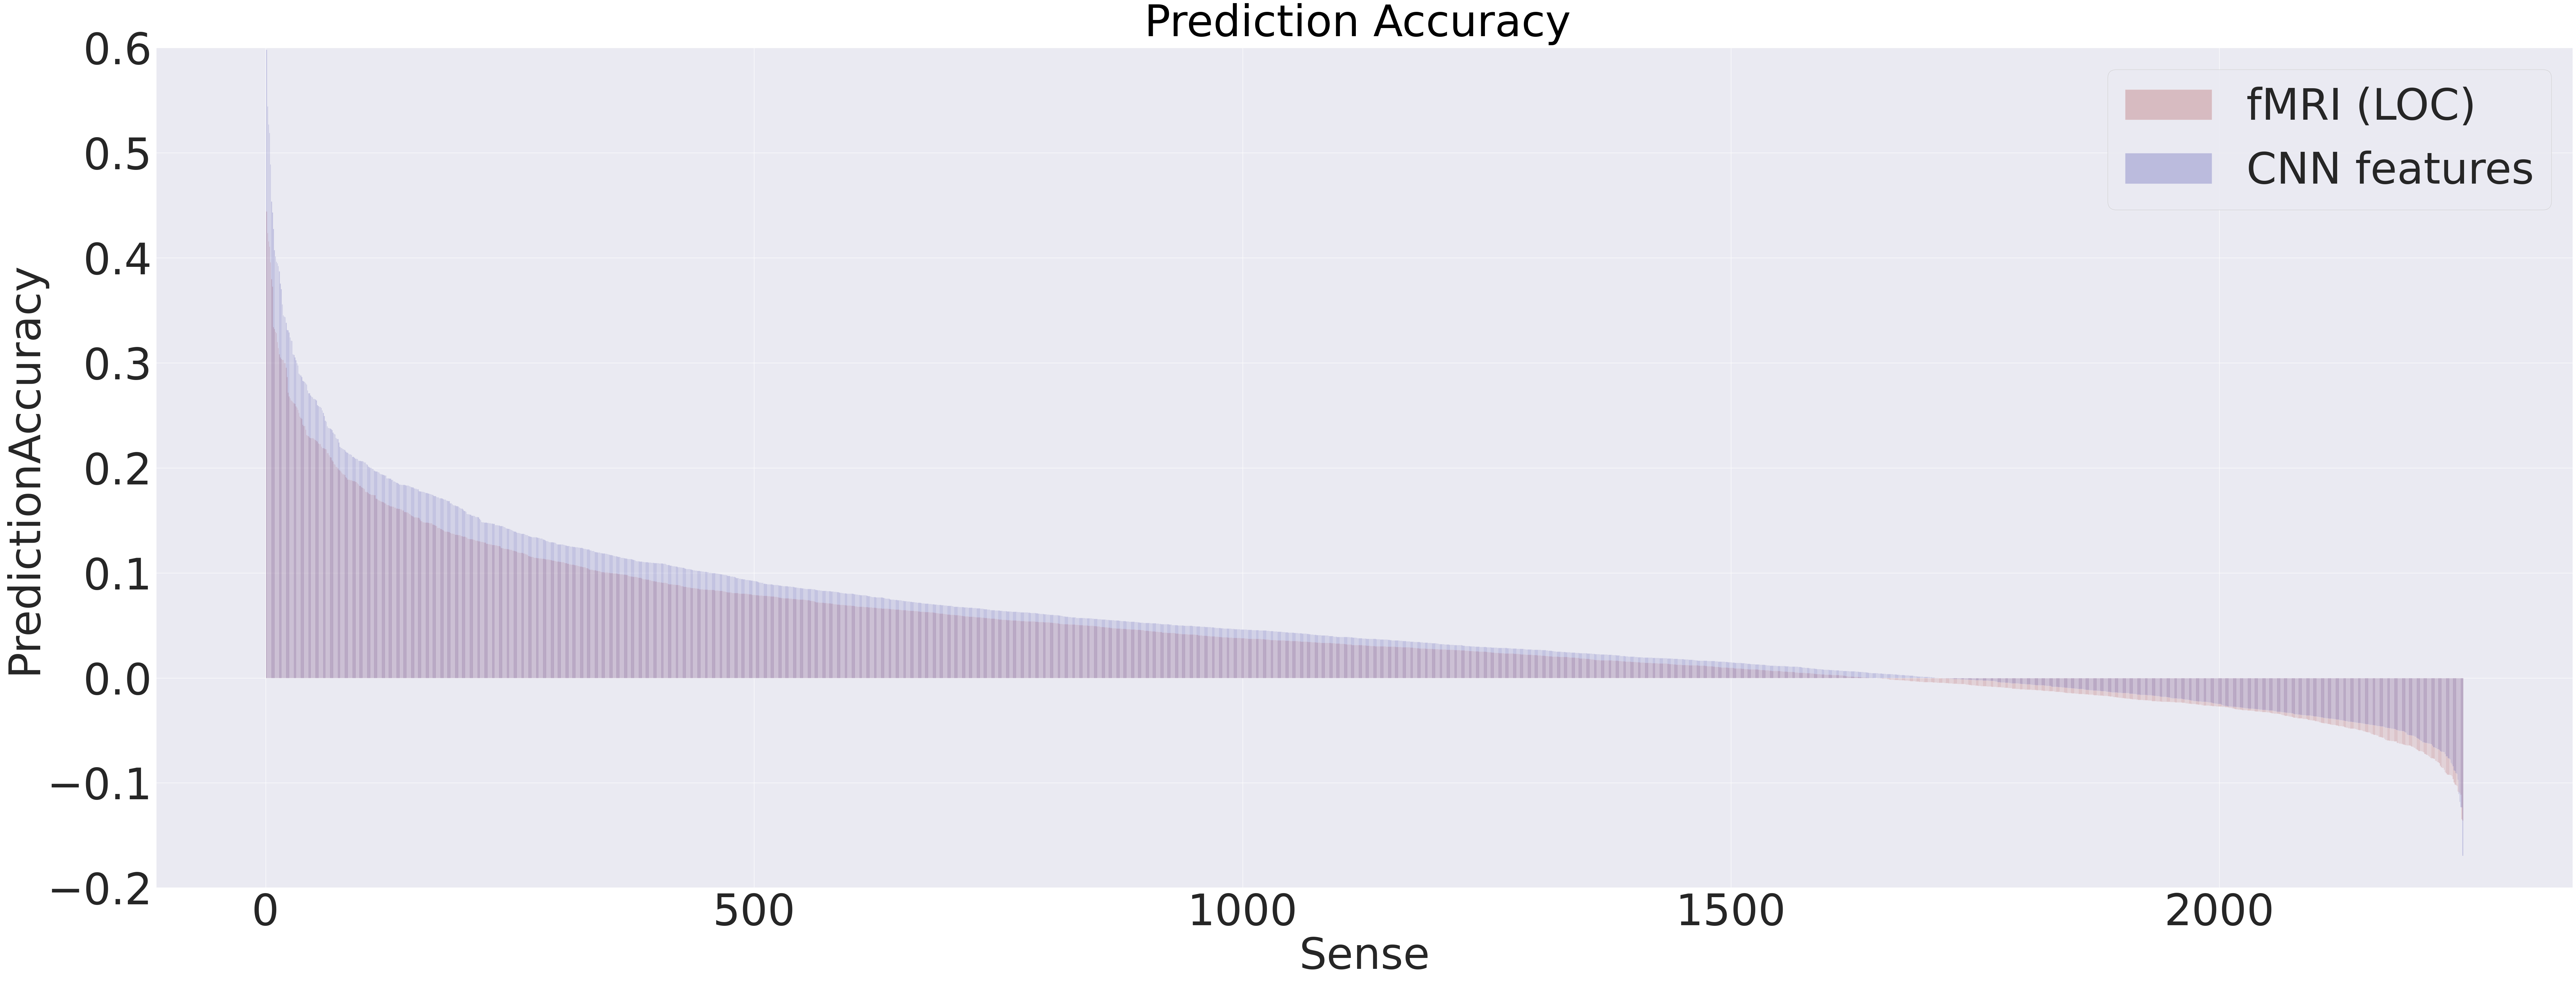

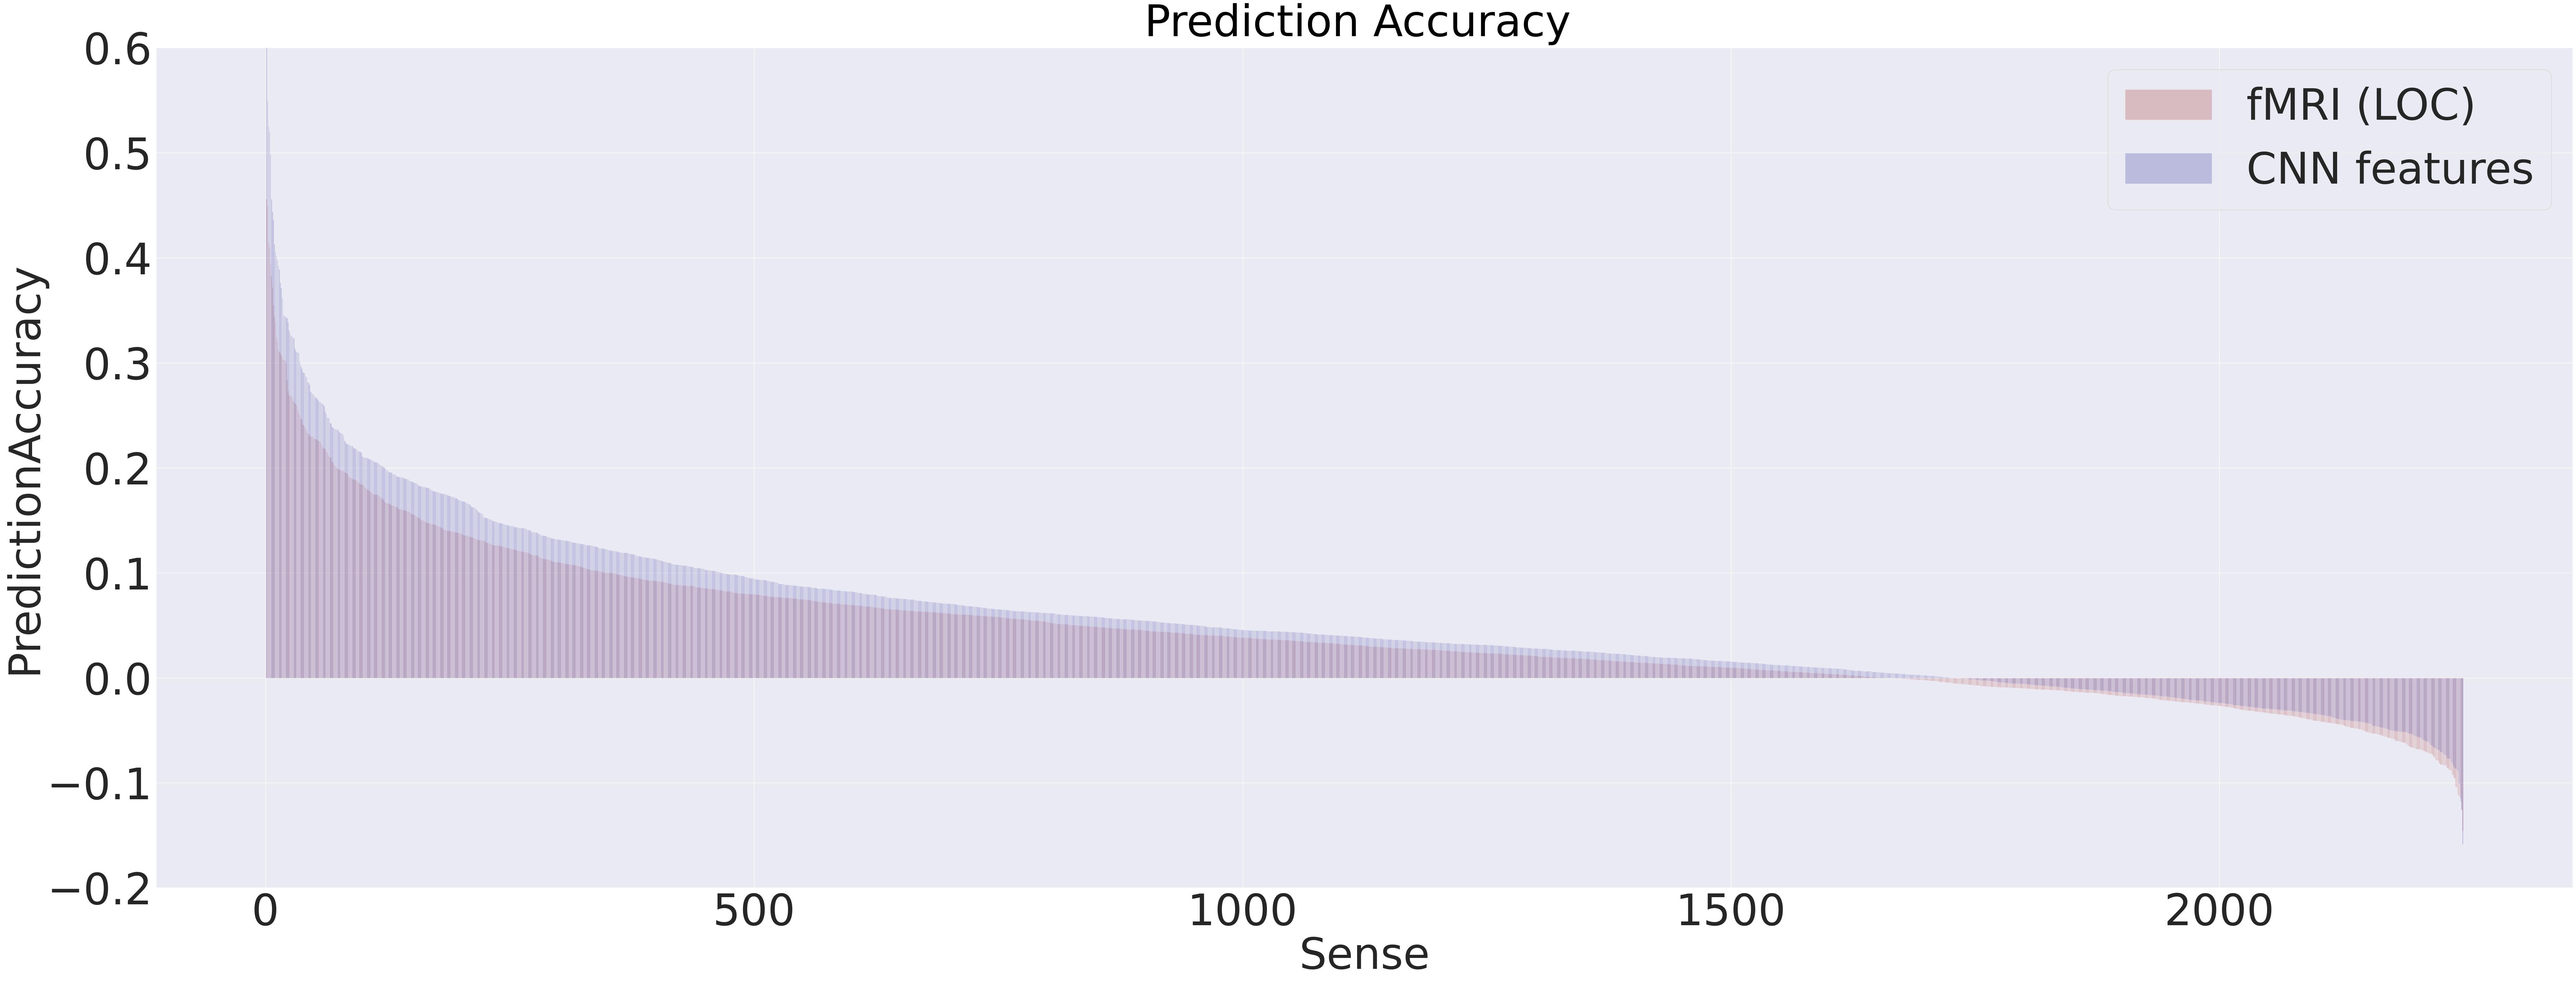

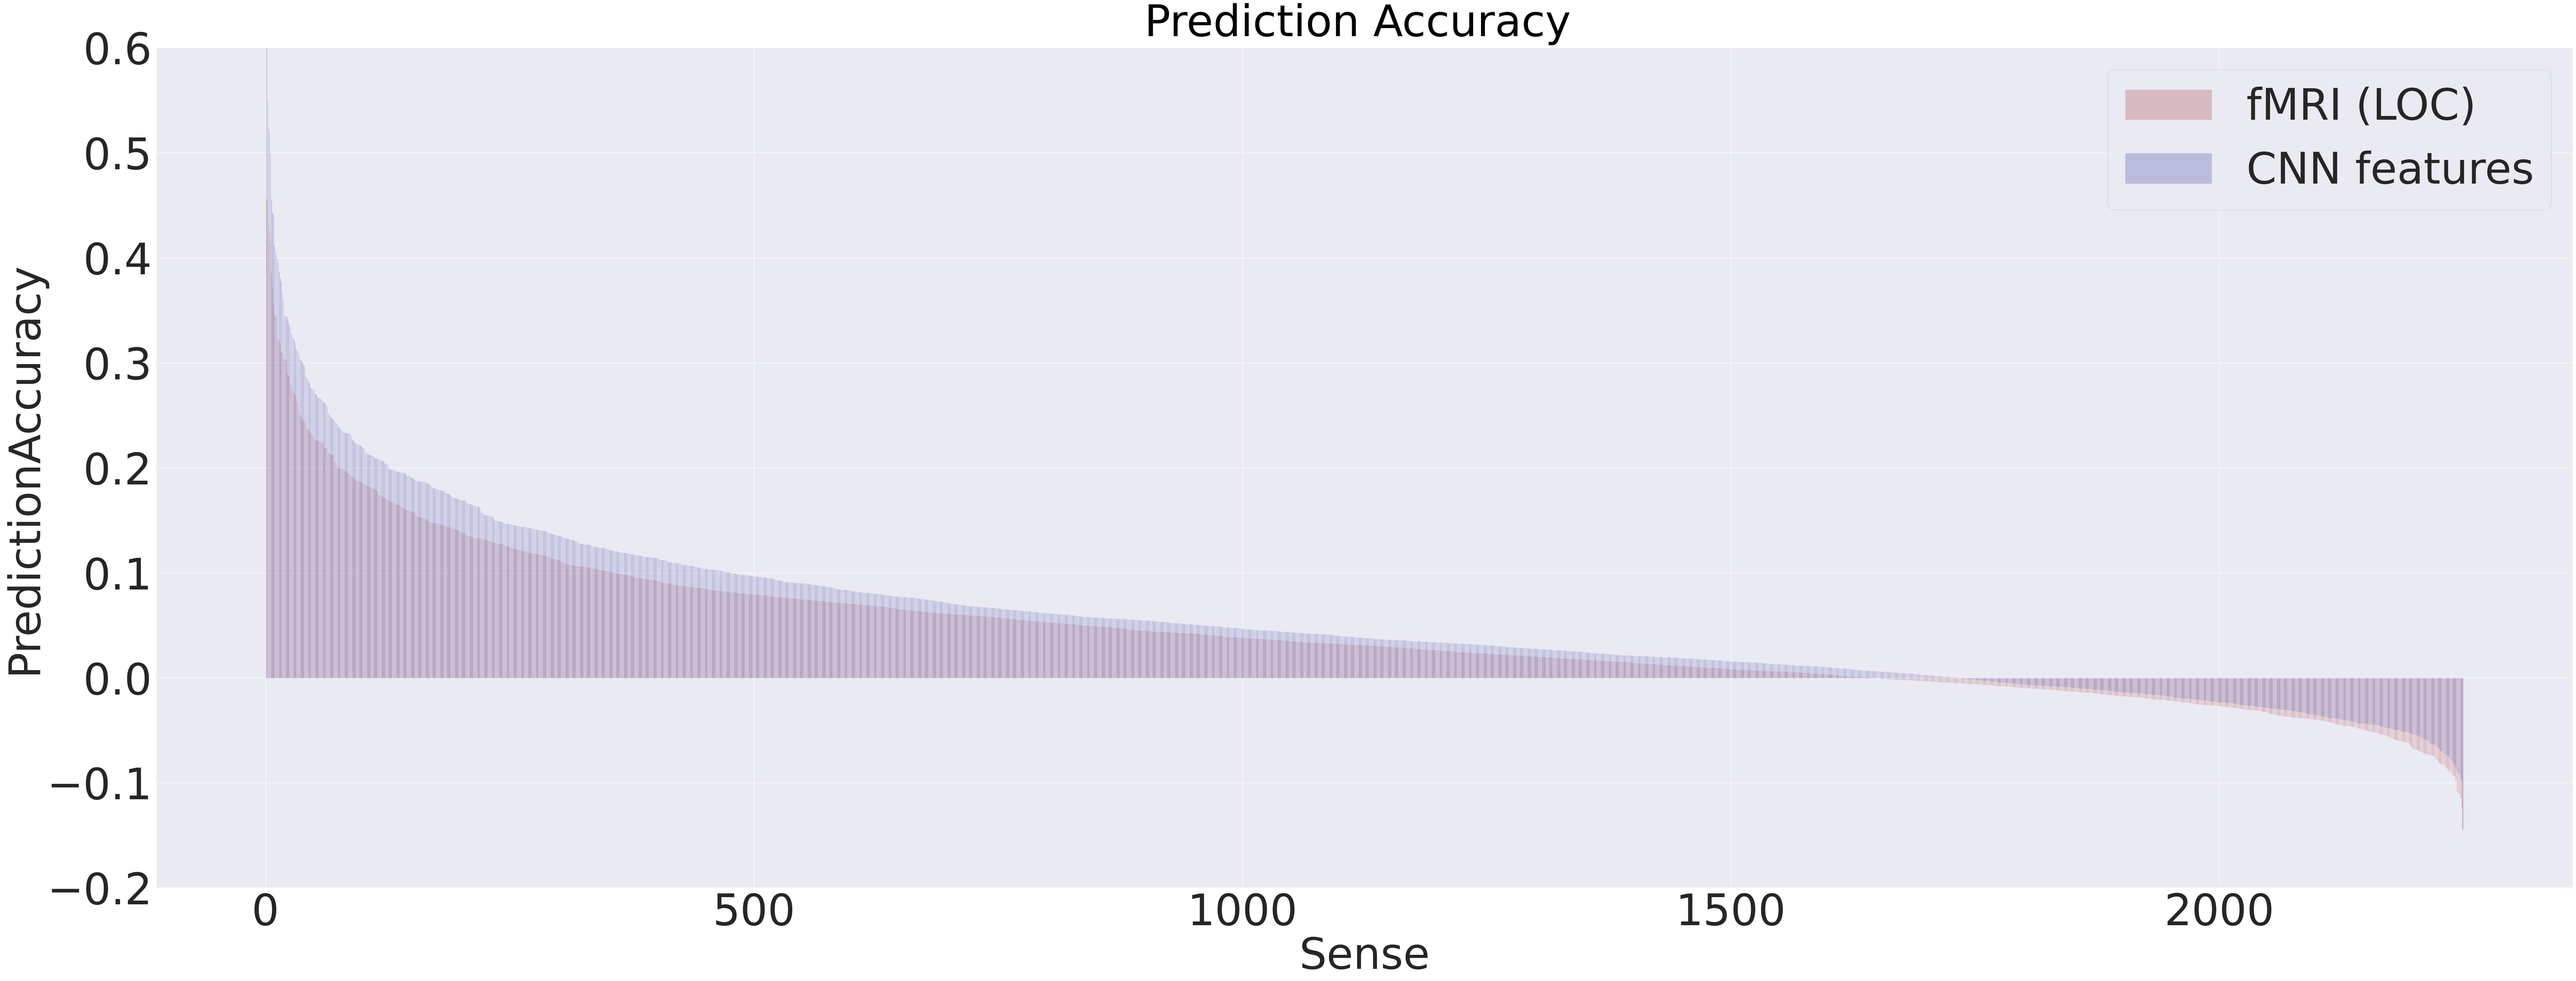

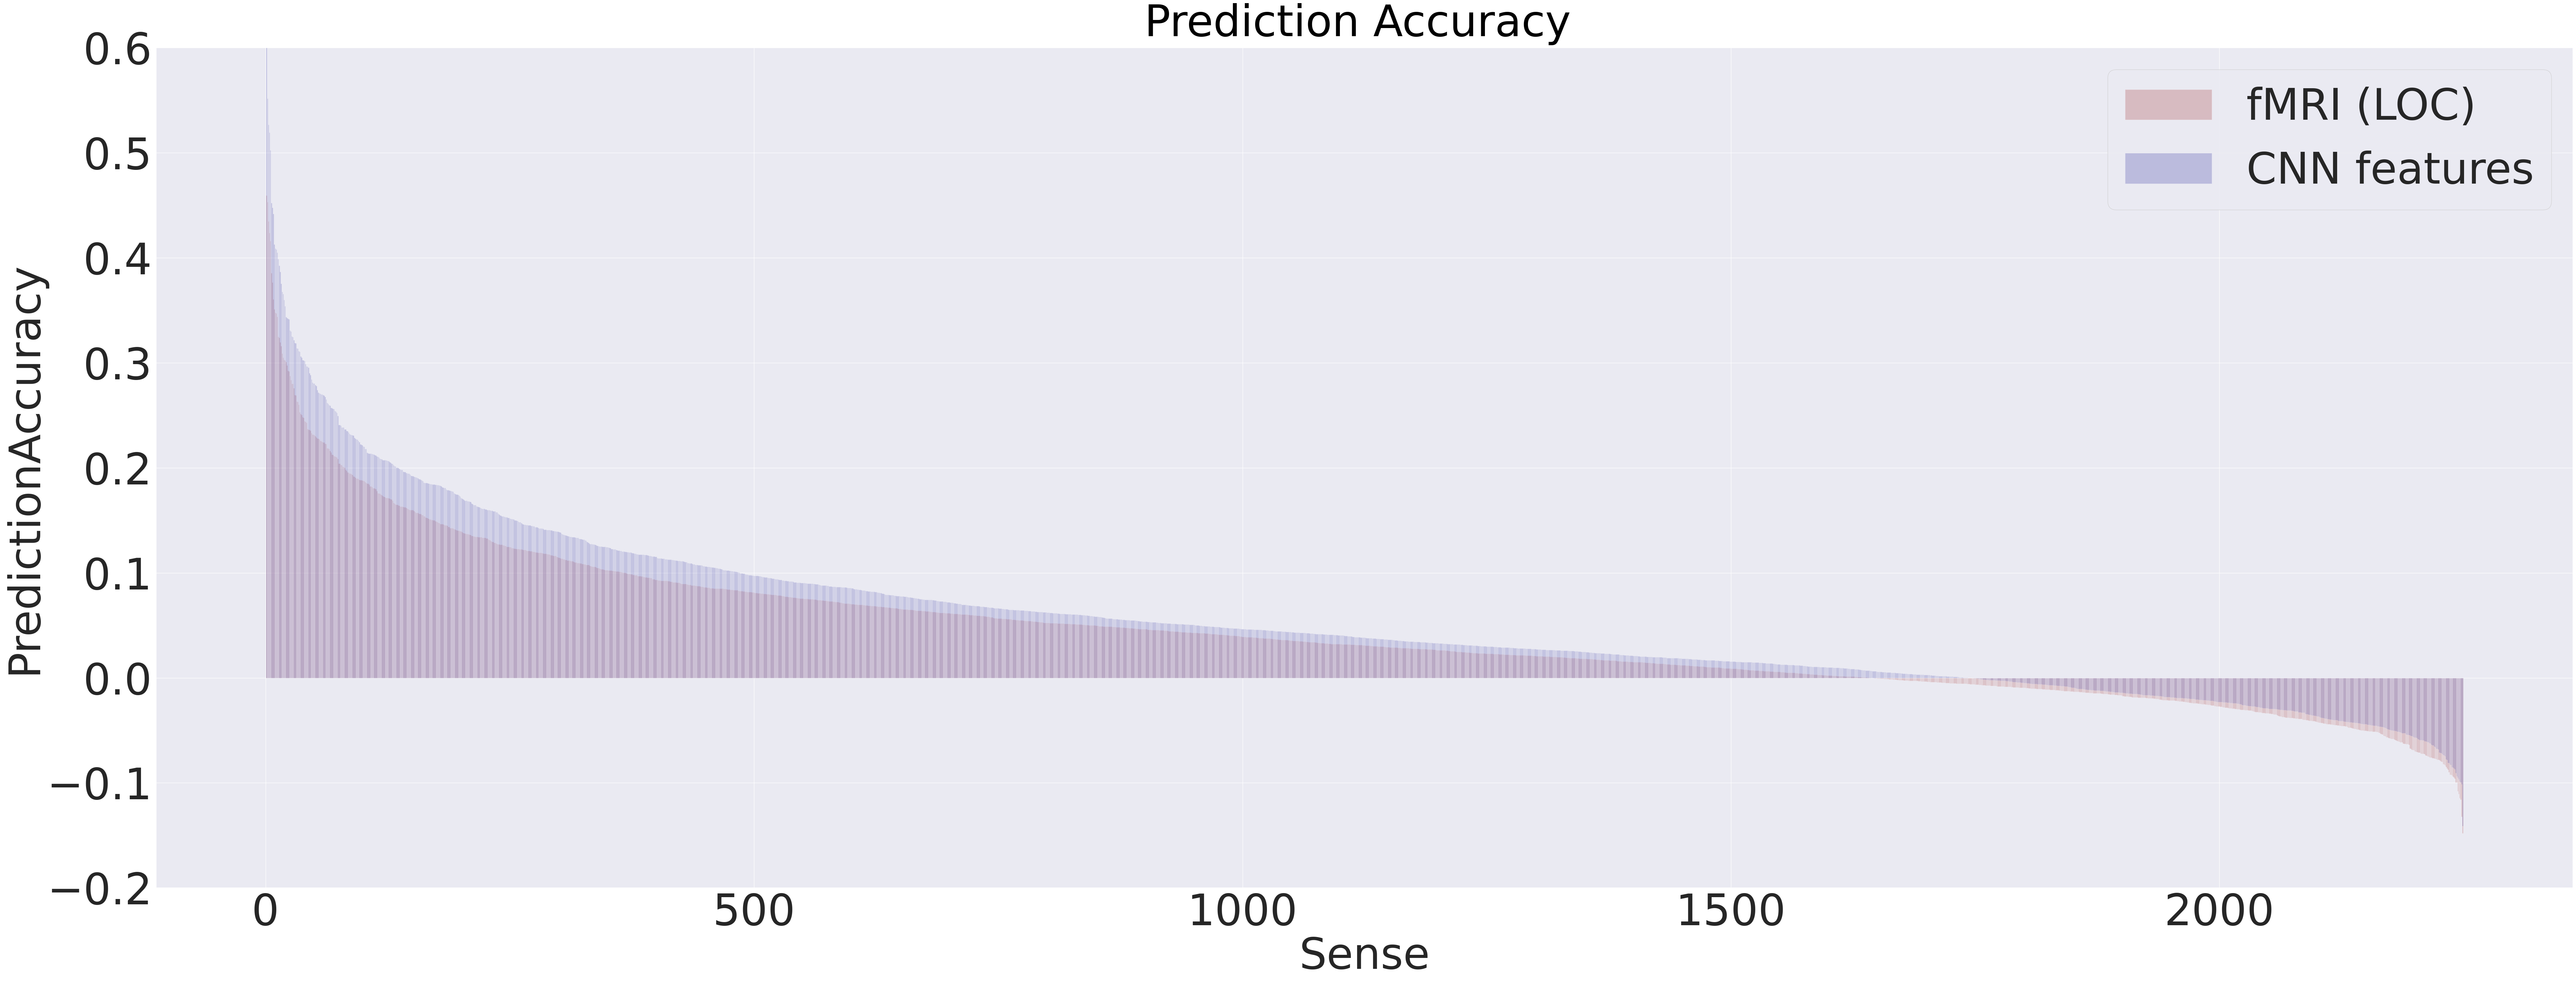

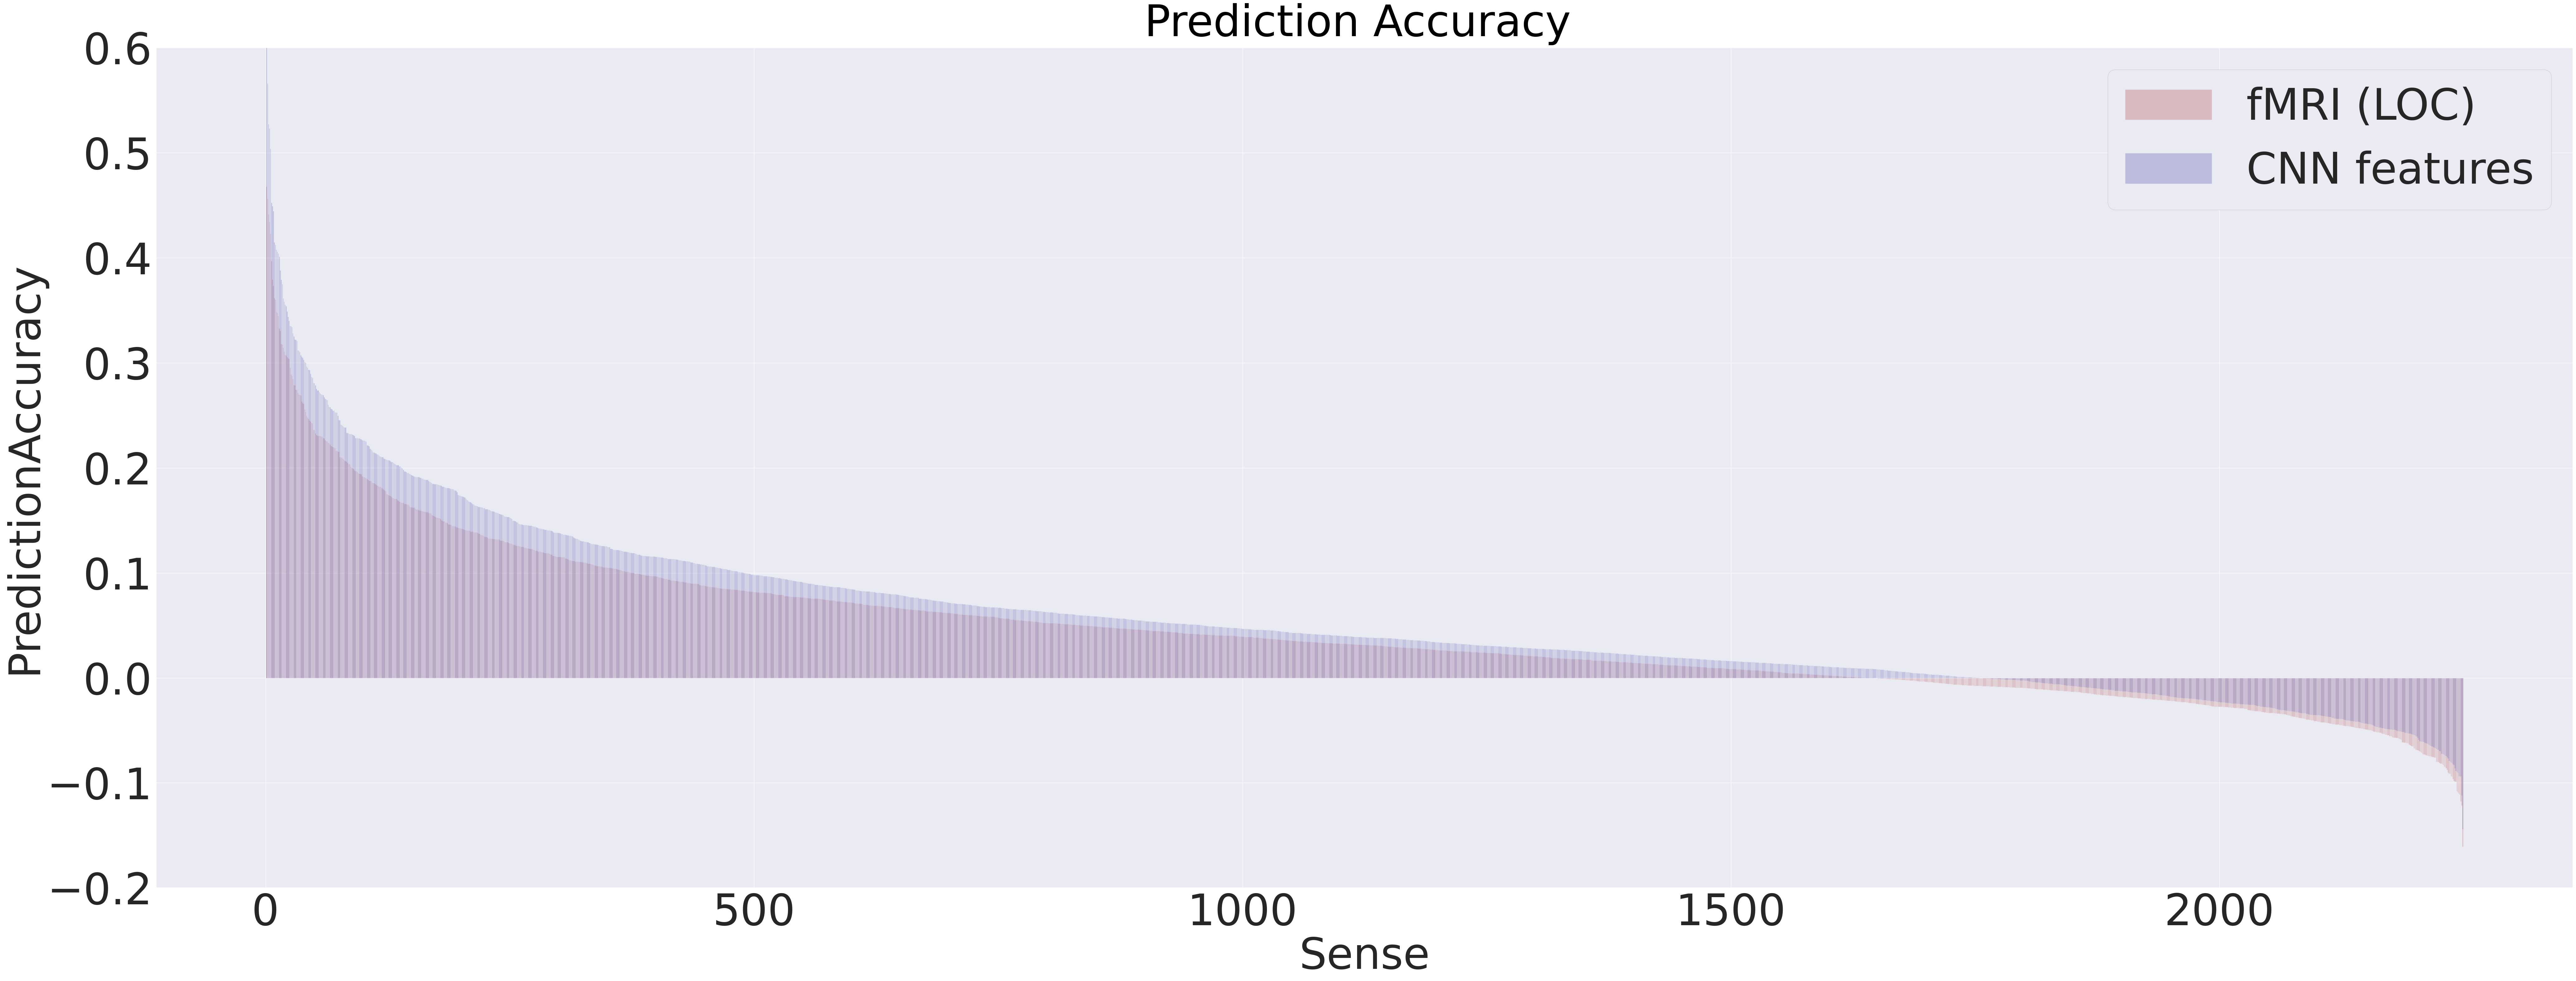

In [9]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# kf9 = KFold(n_splits = 9)
# l2 = 0.0
# randomvector = True
# mean_r_set = np.empty((1, 2250))

# rs = []
# mean_r = {}
# pca = PCA(n_components=pc)
# for train_index, test_index in tqdm(kf9.split(pred_voxels),total=kf9.n_splits):
#     train_voxels = pred_voxels[train_index,]
#     test_voxels =  pred_voxels[test_index,]
#     #print(np.shape([embedding for i, embedding in enumerate(embeddings.values()) if i in train_index]))
#     train_embeddings = np.stack([embedding for i, embedding in enumerate(embeddings.values()) if i in train_index])
#     test_embeddings = np.stack([embedding for i, embedding in enumerate(embeddings.values()) if i in test_index])

#     fmri_mean = np.mean(train_voxels, axis=0)
#     fmri_cov = np.cov(train_voxels, rowvar=False)
# #             print(fmri_mean.shape)
# #             print(fmri_cov.shape)
# #             print(train_voxels.shape)
# #             print(test_voxels.shape)
#     train_voxels_rand = np.random.multivariate_normal(fmri_mean, fmri_cov, (train_voxels.shape[0]))
#     test_voxels_rand = np.random.multivariate_normal(fmri_mean, fmri_cov, (test_voxels.shape[0]))
#     #train_voxels = np.random.rand(train_voxels.shape[0], train_voxels.shape[1])
#     #test_voxels = np.random.rand(test_voxels.shape[0], test_voxels.shape[1])
# #             print("train_rand, ", train_voxels_rand.shape)
# #             print("test_rand, ", test_voxels_rand.shape)
#     _, r = regression(train_voxels_rand, train_embeddings, test_voxels_rand, test_embeddings, l2=l2)
#     rs.append(r)
# rs = np.array(rs)
# print(rs.shape)
# mean_r = np.nanmean(rs, axis=0)
# print(mean_r)


for pc in range(5, 20, 1):
    plt.figure(figsize=(100,35))
    # Set the font dictionaries (for plot title and axis titles)
    title_font = {'fontname':'Arial', 'size':'100', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'100'}
    sns.set()
    #n= len(~np.isnan(mean_r))-1
    n= len(~np.isnan(mean_r_feature))-1

    #mean_r_nonan = mean_r[~np.isnan(mean_r)]
    #print(len(mean_r[~np.isnan(mean_r)]))
    ax = plt.subplot() # Defines ax variable by creating an empty plot
    # Set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(100)
    plt.xlabel('Sense', **axis_font)
    plt.ylabel('PredictionAccuracy', **axis_font)
    plt.title("Prediction Accuracy ", **title_font)

    #Plot the Image!
    # plt.bar(range(0,n), np.sort(mean_r[0:n]), color = 'darkred')

    #plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color=cm.jet(1.*i/len(mean_r_set)), alpha=0.2)
    #plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color=cm.jet(1.*i/len(mean_r_set)), alpha=0.2)
    i = pc - 5
    
    plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color='darkred', label='fMRI (LOC)', alpha=0.2)
    plt.bar(range(0,2250), np.sort(mean_r_feature_set[i])[::-1], color='darkblue', label='CNN features', alpha=0.2)

    plt.legend(prop={'size': 100})

    #ylim
    plt.ylim(-0.2, 0.6) 
    #save figure
    plt.savefig('figures/SensePrediction_LOC_conv5_' + str(pc) + '.png')
    sns.reset_defaults()

In [ ]:
f = open('ThingsWrd2Sns.txt', 'r', encoding='utf-8')
temp = f.readlines()
wordlist = [line.split(',')[0] for idx, line in enumerate(temp) if idx != 0]
nDims = 2250
f.close()

p = os.path.join(os.getcwd(), "predicted_LOC_conv5") 
a = listdir(p)
condition_voxels = {new_list: [] for new_list in wordlist}
conditions = listdir(p)
conditions_filtered = []
for i, c in enumerate(conditions):
    if c in wordlist:        
        conditions_filtered.append(c)
        files = listdir(os.path.join(p, c))
        condition_voxels[c] = [os.path.join(p, c, file_path) for file_path in files]

        
        
print(np.shape(np.load(condition_voxels[random.choice(list(conditions))][0]))[0])
# wordlist = []
# for i, line in enumerate(temp): 
#     if i == 0:
#         continue
#     embedding = line.split(',')
#     wordlist.append(embedding[0]) # create a list of categories from Things
    
word2sense = {new_list: [] for new_list in wordlist} # create word embedding dictionary

for i, line in enumerate(temp):
    if i == 0:
        continue
    embedding = line.split(',')
    embedding.remove('\n')
    embedding_float = ([float(j) for j in embedding[1:]])
    word2sense[embedding[0]] = embedding_float

In [ ]:
plt.figure(figsize=(100,35))
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'100', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'100'}
sns.set()
#n= len(~np.isnan(mean_r))-1
n= len(~np.isnan(mean_r_feature))-1

#mean_r_nonan = mean_r[~np.isnan(mean_r)]
#print(len(mean_r[~np.isnan(mean_r)]))
ax = plt.subplot() # Defines ax variable by creating an empty plot
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(100)
plt.xlabel('Sense', **axis_font)
plt.ylabel('PredictionAccuracy', **axis_font)
plt.title("Prediction Accuracy " + '- # of PCs: ' + str(pc), **title_font)

#Plot the Image!
# plt.bar(range(0,n), np.sort(mean_r[0:n]), color = 'darkred')
print(mean_r_set.shape)
print(mean_r_set[0].shape)

#plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color=cm.jet(1.*i/len(mean_r_set)), alpha=0.2)
#plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color=cm.jet(1.*i/len(mean_r_set)), alpha=0.2)

plt.bar(range(0,2250), np.sort(mean_r_set[1])[::-1], color='darkred', label='random', alpha=0.2)

plt.legend(prop={'size': 100})

#ylim
plt.ylim(-0.2, 0.6) 
#save figure
plt.savefig('figures/SensePrediction_random' + str(pc) + 'pc.png')
sns.reset_defaults()

In [ ]:
class embedding_encoder:
    def __init__(self, fmri_path="predicted_LOC_conv5", embedding_file="ThingsWrd2Sns.txt"): #fmri is the root path, word2sense is dictionary 
        f = open(embedding_file, 'r', encoding='utf-8')
        temp = f.readlines()
        wordlist = [line.split(',')[0] for idx, line in enumerate(temp) if idx != 0]
        nDims = 2250
        f.close()
        
        word2sense = {new_list: [] for new_list in wordlist} # create word embedding dictionary
        for i, line in enumerate(temp):
            if i == 0:
                continue
            embedding = line.split(',')
            embedding.remove('\n')
            embedding_float = ([float(j) for j in embedding[1:]])
            word2sense[embedding[0]] = embedding_float
        
        condition_voxels = {new_list: [] for new_list in wordlist}
        p = os.path.join(os.getcwd(), fmri_path) 
        conditions = sorted(listdir(p))
        conditions_filtered = []
        for c in conditions:
            if c in wordlist:
                conditions_filtered.append(c)
                files = listdir(os.path.join(p, c))
                condition_voxels[c] = sorted([os.path.join(p, c, file_path) for file_path in files])
                
        #voxel values paths?
        
        #self.fmri = list_folder
        self.n_dims = nDims
        self.n_voxels = np.shape(np.load(condition_voxels[random.choice(list(conditions_filtered))][0]))[0]
        self.conditions = conditions_filtered
        self.condition_voxels = OrderedDict(condition_voxels)
        self.embedding = OrderedDict(word2sense)
        
        # take the word from fmri, find the word (key) in word2sense, 
        # take its embedding (value)        
        
def cv_regression_embedding(embedding_encoder, l2=0.0):
    rs = []
    step = 70
    nfolds = 20
    for start in range(0, len(embedding_encoder.conditions), step):
        
#        print(start)
        test_conditions = embedding_encoder.conditions[start:start+step]
#        print(test_conditions)
        train_conditions = [c for c in embedding_encoder.conditions if c not in test_conditions]
        train_voxels = np.stack([np.load(embedding_encoder.condition_voxels[condition]) for condition in train_conditions])
        train_embedding = np.stack([embedding_encoder.embedding[condition] for condition in train_conditions])
        test_voxels = np.stack([np.load(embedding_encoder.condition_voxels[condition]) for condition in test_conditions])
        test_embedding = np.stack([embedding_encoder.embedding[condition] for condition in test_conditions])
        _, r = regression(train_voxels, train_embedding, test_voxels, test_embedding, l2=l2)
        rs.append(r)

In [ ]:
encoder = embedding_encoder("predicted_LOC_conv5", "ThingsWrd2Sns.txt")

rs = []
step = 70
nfolds = 20
conditions = sorted(encoder.conditions)
test_conditions = conditions[0:0+step]
train_conditions = [c for c in conditions if c not in test_conditions]
test_condition_paths = [encoder.condition_voxels[condition] for condition in test_conditions]
for test_voxel_path in test_voxels_paths:
    for voxel in test_condition_path:
        print(np.load(item))
#test_voxels = np.array([np.load(item) for item in test_voxels_paths])
#print(np.shape(test_voxels))

#test_voxels = np.stack([np.load(path) for path in encoder.condition_voxels[condition] for condition in test_conditions])
#print(test_voxels)
a = [np.shape((encoder.condition_voxels[condition]))[0] for condition in test_conditions]
print(np.sum(a))
test_embeddings = np.stack(np.tile(encoder.embedding[condition], (np.shape(encoder.condition_voxels[condition])[0], 1)) for condition in test_conditions)
print(np.shape(test_embeddings))

train_voxels = np.stack(np.load(path) for path in encoder.condition_voxels[condition] for condition in train_conditions)
print(np.shape(train_voxels))
a = [np.shape((encoder.condition_voxels[condition]))[0] for condition in train_conditions]
print(np.sum(a))
train_embeddings = np.stack(np.tile(encoder.embedding[condition], (np.shape(encoder.condition_voxels[condition])[0], 1)) for condition in train_conditions)
print(np.shape(train_embeddings))

#for condition in train_conditions:
#    voxel_paths = encoder.condition_voxels[condition]
#train_voxels = np.vstack((train_voxels, voxels))
#    embeddings = np.vstack((train_embeddings, encoder.embedding[condition]))
    #embeddings = np.tile(encoder.embedding[condition], (np.shape(voxels)[0], 1))
#    print(np.shape(embeddings))
    #train_embeddings = np.vstack((train_embeddings, embeddings))
    #train_embeddings = 

#print(np.shape(train_voxels))
#print(np.shape(train_embeddings))

In [ ]:
encoder = embedding_encoder("predicted_LOC_conv5", "ThingsWrd2Sns.txt")
cv_regression_embedding(encoder)

In [ ]:
##Compute feature activations for THINGS dataset
import os.path
import csv
import pandas as pd
new_condition_features = {}
if os.path.isfile(“Things_” + layer + “.csv”):
     features = pd.read_csv(“Things_” + layer + “.csv”, sep=“,”, header=None)
else:
    ## ImageFolder must contain subfolders of images:
    image_dir = ‘/Users/cmagri1/OneDrive - Johns Hopkins/Project-Word2Sense//THINGSdataset/Main/images’
    print(‘Extracting new stimuli features’)
    new_conditions = listdir(image_dir)
    new_condition_features = {}
    for c in tqdm(new_conditions):
        c_name = c.split(‘/’)[-1]
        if (Wrd2Sense[‘item’]==c_name).any(): ##if it’s both in Word2Sense and Things -> it should be the case but just making sure
            stimuli = listdir(c)
            #resize according to resolution and square the image
            stimuli = [image_to_tensor(s, resolution=resolutionval) for s in stimuli]
            stimuli = torch.stack(stimuli)
            if torch.cuda.is_available():
                stimuli = stimuli.cuda()
            with torch.no_grad():
                #average across the same category
                feats = model(stimuli).mean(dim=0).cpu().numpy()
            new_condition_features[c_name] = feats
    features = pd.DataFrame(new_condition_features).transpose()
    features.to_csv(os.getcwd() + “/Things_” + layer + “.csv”, index = True, header=False)
    


from tqdm import tqdm
from sklearn.model_selection import KFold
#predicting 1 word2sense using the simulated brain data
# create the range 1 to 25
# rn = range(1,ROIpred.shape[0])
#let's do 9 splits...
kf9 = KFold(n_splits = 9)
# for train, test in kf9.split(ROIpred):
#     print('okay')
# print("%s" % (train))
# print("%s" % (test))
# len(train)
l2 = 0.0
# to get the values from our data, we use np.take() to access a value at particular index
rs = []#[[] for i in (0,(features.values.shape[1]-1))]
mean_r = {}
rowcounter = -1
# for (senseName, senseData) in tqdm(features.iteritems(), total=len(features.columns)):
#     print(senseName)
for train_index, test_index in tqdm(kf9.split(ROIpred),total=kf9.n_splits):
    train_features = ROIpred[train_index,]
    test_features =  ROIpred[test_index,]        
    train_Y = np.take(features.values,train_index, axis=0) #jsut the first sense for now
    test_Y = np.take(features.values,test_index, axis=0)
    
#     for sense in tqdm(range(0,features.values.shape[1])):
    _,r = regression_iter(train_features, train_Y, test_features,  test_Y, l2=l2)
    rs.append(r)
            
mean_r = np.mean(rs, axis=0)
#Saved information
np.save(os.getcwd() + "/data-cv_regress/Word2SensePrediction_Sub" + str(Sub) + '_' + ROI + "_" + layer, mean_r)